**Set random seed for reproducability**

In [1]:
import os
import numpy as np 
import tensorflow as tf
randseed = 42
np.random.seed(randseed)
tf.random.set_seed(randseed)
os.environ['PYTHONHASHSEED']=str(randseed)

**Import packages**

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
from keras import backend as K
from keras.models import Sequential, load_model 
from keras.layers import Dense, Dropout, LSTM, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score

**Read in dataset**

In [3]:
#Read in the Dataset
original = pd.read_csv('/kaggle/input/stocks/SHP.csv') 
original['Date'] = pd.to_datetime(original.Date) 
original.head()

Date  Open  High  Low  Close  Volume  Earnings Yield (EY)  \
0 1999-01-01   820   820  800    820       0                  5.6   
1 1999-01-04   820   825  800    825  542800                  5.6   
2 1999-01-05   815   815  810    815    1000                  5.7   
3 1999-01-06   825   840  825    840   53000                  5.5   
4 1999-01-07   845   850  845    845   56970                  5.5   

   Dividend Yield (DY)  P:E Ratio (P:E) Trades Trade Value  \
0                  1.7        17.857143      -           -   
1                  1.7        17.857143      -           -   
2                  1.7        17.543860      -           -   
3                  1.7        18.181818      -           -   
4                  1.7        18.181818      -           -   

   Total Return Index (TRI)  
0                902.101187  
1                907.601804  
2                896.600570  
3                924.103655  
4                929.604272

**Feature Engineering**

In [4]:
forecastHorizon = 5

#Create new dataframe
df = pd.DataFrame(data = original['Date'])  

#Target Returns (Weekly)
df['Target'] = np.log(original['Close'].shift(-forecastHorizon) / original['Close'])

#Returns from the closing price
df['Returns'] = np.log((original['Close']) / original['Close'].shift(forecastHorizon))

#Lagged Variations of returns
df['Returns1'] = np.log((original['Close']) / original['Close'].shift(1))
df['Returns2'] = np.log((original['Close']) / original['Close'].shift(2))
df['Returns3'] = np.log((original['Close']) / original['Close'].shift(3))
df['Returns4'] = np.log((original['Close']) / original['Close'].shift(4))

#Simple Moving Average (SMA) and Exponentially-weighted Moving Average (EWMA) - 5, 10, 20, 50, 200 days
numDays = 5
df['SMA (5)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (5)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 10
df['SMA (10)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (10)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 20
df['SMA (20)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (20)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 50
df['SMA (50)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (50)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 200
df['SMA (200)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (200)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

#Relative Strength Index (RSI)
numDays = 14
diff = original['Close'].diff(1)
up, down = diff.copy(), diff.copy()
up[up < 0] = 0
down[down > 0] = 0
EWMAu = up.ewm(span = numDays, min_periods = numDays).mean()
EWMAd = down.abs().ewm(span = numDays, min_periods = numDays).mean()
RS = EWMAu / EWMAd
df['RSI'] = 100.0 - (100.0 / (1.0 + RS))

#Moving Average Convergence Divergence (MACD)
df['MACD'] = df['Returns'].ewm(span = 12, min_periods = 12).mean()  - df['Returns'].ewm(span = 26, min_periods = 26).mean() 

#Commodity Channel Index (CCI) 
df['Typical Price'] = (original['High'] + original['Low'] + original['Close']) / 3
numDays = 20
df['CCI'] = (df['Typical Price'] - df['Typical Price'].rolling(numDays).mean()) / (0.015 * df['Typical Price'].rolling(numDays).std())

#Stochastic Oscillator (SO)
numDays = 14
df['SO'] = ((df['Returns'] - df['Returns'].rolling(numDays).min()) / (df['Returns'].rolling(numDays).max() - df['Returns'].rolling(numDays).min())) * 100

#Variations of Returns
df['TRI'] = np.log(original['Total Return Index (TRI)'] / original['Total Return Index (TRI)'].shift(forecastHorizon))
df['Returns Open'] = np.log(original['Open'] / original['Open'].shift(forecastHorizon))
df['Returns Low'] = np.log(original['Low'] / original['Low'].shift(forecastHorizon))
df['Returns High'] = np.log(original['High'] / original['High'].shift(forecastHorizon))
df['Returns High/Open'] = np.log(original['High'] / original['Open'].shift(forecastHorizon))
df['Returns High/Low'] = np.log(original['High'] / original['Low'].shift(forecastHorizon))
df['Returns High/Close'] = np.log(original['High'] / original['Close'].shift(forecastHorizon))
df['Returns Close/Open'] = np.log(original['Close'] / original['Open'].shift(forecastHorizon))
df['Returns Close/Low'] = np.log(original['Close'] / original['Low'].shift(forecastHorizon))
df['Returns Close/High'] = np.log(original['Close'] / original['High'].shift(forecastHorizon))
df['Returns Open/Low'] = np.log(original['Open'] / original['Low'].shift(forecastHorizon))
df['Typical Price'] = np.log(df['Typical Price'] / df['Typical Price'].shift(forecastHorizon))

#Set date to index
df.index = df['Date'] 

#Drop columns that aren't needed
df.drop(['Date'], axis=1, inplace=True)

#Drop NaNs
df = df.dropna()

#Remove 150 datapoints so no data leakage between hyperparameter optimisation window
df = df[150:]

df.head()

Target   Returns  Returns1  Returns2  Returns3  Returns4  \
Date                                                                     
2000-05-11 -0.013986  0.013986 -0.006920  0.006969  0.006969  0.013986   
2000-05-12 -0.056753  0.020907  0.006920  0.000000  0.013889  0.013889   
2000-05-15 -0.035846 -0.007018 -0.020907 -0.013986 -0.020907 -0.007018   
2000-05-16 -0.014185 -0.007018  0.000000 -0.020907 -0.013986 -0.020907   
2000-05-17 -0.035339 -0.006920  0.013986  0.013986 -0.006920  0.000000   

             SMA (5)  EWMA (5)  SMA (10)  EWMA (10)  ...  Returns Open  \
Date                                                 ...                 
2000-05-11  0.014076  0.015485  0.028214   0.019153  ...      0.013986   
2000-05-12  0.015420  0.017293  0.024420   0.019472  ...      0.013986   
2000-05-15  0.009776  0.009189  0.017835   0.014656  ...      0.005579   
2000-05-16  0.005556  0.003787  0.010537   0.010715  ...     -0.007018   
2000-05-17  0.002787  0.000218  0.007740   0.007509  ...     -0.009811   

            Returns Low  Returns High  Returns High/Open  Returns High/Low  \
Date                                                                         
2000-05-11     0.014185      0.013986           0.013986          0.028171   
2000-05-12     0.013986      0.018094           0.020907          0.020907   
2000-05-15    -0.008427     -0.008310           0.005579          0.005579   
2000-05-16    -0.008427     -0.006920           0.006969          0.006969   
2000-05-17    -0.009811      0.000000           0.011096          0.011096   

            Returns High/Close  Returns Close/Open  Returns Close/Low  \
Date                                                                    
2000-05-11            0.013986            0.013986           0.028171   
2000-05-12            0.020907            0.020907           0.020907   
2000-05-15            0.005579           -0.007018          -0.007018   
2000-05-16            0.006969           -0.007018          -0.007018   
2000-05-17            0.000000            0.004175           0.004175   

            Returns Close/High  Returns Open/Low  
Date                                              
2000-05-11            0.013986          0.028171  
2000-05-12            0.018094          0.013986  
2000-05-15           -0.020907          0.005579  
2000-05-16           -0.020907         -0.007018  
2000-05-17           -0.006920         -0.009811  

[5 rows x 32 columns]

**Model Helper Functions**

In [5]:
def windowInfo(w, sequencelength, start, trainingSize, validationSize, end):
  '''
  Prints the current window information
  @params:
    w - Window Number
    sequencelength - Length of a single input sequence
    start - First datapoint index
    trainingSize - Size of the training set
    validationSize - Size of the validation set
    end - Last datapoint index
  '''
  print('Window ' + str(w + 1) + ': ')
  print('Training datapoints: ' + str(start - sequencelength) + " - " + str(start + trainingSize - 1 - sequencelength))
  print('Validation datapoints: ' + str(start + trainingSize - sequencelength) + " - " + str(start + trainingSize + validationSize - 1 - sequencelength))
  print('Testing datapoints: ' + str(start + trainingSize + validationSize - sequencelength)  + " - " + str(end - 1 - sequencelength))
  print()

def split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end):
  '''
  Function to split the data into a window required for Keras RNNs
  @params:
    dataset - data to be used
    sequencelength - Number of datapoints in a single input sequence
    features - Number of features in the dataset
    scaler - Initialised MinMaxScaler
    start - First datapoint index
    trainingSize - Size of the training set
    validationSize - Size of the validation set
    testingSize - Size of the testing set
    end - Last datapoint index
  @returns:
    scaler - Scaler that is fit on the training data
    x_train - Scaled Training input 
    y_train - Scaled Training output 
    y_trainUnscaled - Unscaled training output 
    x_val - Scaled validation input 
    y_val - Scaled validation output 
    y_valUnscaled - Unscaled validation output 
    x_test - Scaled testing input 
    y_test - Unscaled testing output 
  '''
  #Extracting target variables for the test and train set
  train = scaler.fit_transform(dataset[start - sequencelength : start + trainingSize, :])
  unscaled_train = dataset[start - sequencelength : start + trainingSize , 0]

  x_train = []
  y_train = []
  y_trainUnscaled = []
  for i in range(sequencelength, len(train)):
    x_train.append(train[i - sequencelength + 1 : i + 1, 1:])
    y_train.append(train[i, 0])
    y_trainUnscaled.append(unscaled_train[i])

  x_train = np.array(x_train)
  x_train = x_train.reshape((x_train.shape[0], sequencelength, features))
  y_train = np.array(y_train)
  y_trainUnscaled = np.array(y_trainUnscaled)

  #Splitting the validation set into input and output arrays
  val = scaler.transform(dataset[start + trainingSize - sequencelength : end - testingSize, :])
  unscaled_val = dataset[start + trainingSize - sequencelength : end - testingSize , 0]

  x_val = []
  y_val = []
  y_valUnscaled = []
  for i in range(sequencelength, len(val)):
    x_val.append(val[i - sequencelength + 1 : i + 1, 1:])
    y_val.append(val[i, 0])
    y_valUnscaled.append(unscaled_val[i])

  x_val = np.array(x_val)
  x_val = x_val.reshape((x_val.shape[0], sequencelength, features))
  y_val = np.array(y_val)
  y_valUnscaled = np.array(y_valUnscaled)

  #Splitting the testing set into input an array
  test = scaler.transform(dataset[start + trainingSize + validationSize - sequencelength : end, :])
  unscaled_test = dataset[start + trainingSize + validationSize - sequencelength : end, 0]

  x_test = []
  y_test = []
  for i in range(sequencelength, len(test)):
    x_test.append(test[i - sequencelength + 1 : i + 1, 1:])
    y_test.append(unscaled_test[i])

  x_test = np.array(x_test) 
  x_test = x_test.reshape((x_test.shape[0], sequencelength, features))
  y_test = np.array(y_test)

  return scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test

def makePredictions(model, predictions, x_train, x_val, x_test):
  '''
  Performs inference using the model
  @params:
    model - LSTM or GRU (Keras Framework)
    predictions - Array that stores predictions across windows
    x_train - Training input data
    x_val - Validation input data
    x_test - Testing input data
  @returns:
    predictions - Updated prediction array
    trainingPredictions - Training set predictions
    valPredictions - Validation set predictions
    testingPredictions - Testing set predictions
  '''
  #Forecasts on training set
  temp = x_train
  trainingPredictions = model.predict(x_train)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((trainingPredictions, temp[:,:features]), axis=1)
  trainingPredictions = scaler.inverse_transform(invPred)[:,0]
  trainingPredictions = trainingPredictions.reshape((trainingPredictions.shape[0], 1))

  #Forecasts on validation set
  temp = x_val
  valPredictions = model.predict(x_val)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((valPredictions, temp[:,:features]), axis=1)
  valPredictions = scaler.inverse_transform(invPred)[:,0]
  valPredictions = valPredictions.reshape((valPredictions.shape[0], 1))

  #Forecasts on test set
  temp = x_test
  testingPredictions = model.predict(x_test)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((testingPredictions, temp[:,:features]), axis=1)
  testingPredictions = scaler.inverse_transform(invPred)[:,0]
  testingPredictions = testingPredictions.reshape((testingPredictions.shape[0], 1))

  #Keep track of overall predictions
  predictions[start - sequencelength: start - sequencelength + testingSize, :] = testingPredictions

  return predictions, trainingPredictions, valPredictions, testingPredictions

def performance(actual, predictions, sett):
  '''
  Calculate the performance metrics for a specific window
  @params:
    actual - True values
    predictions - predicted values
    sett - Training/Validation/Testing set
  '''
  mse = mean_squared_error(actual, predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(actual, predictions)
  r2 = r2_score(actual, predictions)

  print("Results on " + sett + " set: ")
  print('MSE = ' + str(mse))
  print('RMSE = ' + str(rmse))
  print('MAE = ' + str(mae))
  print('R-Squared = ' + str(r2))
  print()

  return 

def evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, trainingPredictions, valPredictions, testingPredictions):
  '''
  Evaluates the performance of the model
  @params:
    y_trainUnscaled - True Training set values 
    y_valUnscaled - True validation set values
    y_test - True Testing set values
    trainingPredictions - Predicted Training set values 
    valPredictions - Predicted validation set values
    testingPredictions - Predicted Testing set values
  '''
  performance(y_trainUnscaled, trainingPredictions, 'Training')
  performance (y_valUnscaled, valPredictions, 'Validation')
  performance(y_test, testingPredictions, 'Testing')

  return 

**LSTM model**

In [6]:
def create_lstm():
  '''
  Function to create an LSTM using the Keras Framework
  @returns
    model - Compiled LSTM
  '''
  #hyperparameters
  learningRate = 0.004836927180682221
  dropout = 0.18507824608274567
  units = 227
  
  #Construct LSTM
  model = Sequential()
  model.add(LSTM(units=units, return_sequences=True, input_shape=(sequencelength, features)))
  model.add(LSTM(units=units, dropout=dropout))
  model.add(Dense(1))

  #LSTM compile
  ao = Adam(lr=learningRate, amsgrad=True)
  model.compile(loss='mae', optimizer=ao, metrics=['mse','mae', 'mape', 'msle'])

  return model

def train_lstm(model, x_train, y_train, x_val, y_val):
  '''
  Function to train the LSTM
  @params:
    model - Keras LSTM model
    x_train - Training Input
    y_train - Training Output
    x_val - Validation Input
    y_val - Validation Output
  @returns:
    history - Model history
    model - Best model according to early stopping
  '''
  batchSize = 20
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
  mc = ModelCheckpoint('./LSTM.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
  history = model.fit(x_train, y_train, epochs=150, batch_size=batchSize, verbose=0, validation_data = (x_val, y_val), callbacks=[es, mc])
  model = load_model('./LSTM.h5')
  return history, model

**LSTM Forecasting Implementation**

Window 1: 
Training datapoints: 0 - 999
Validation datapoints: 1000 - 1099
Testing datapoints: 1100 - 1249

Results on Training set: 
MSE = 0.001319691947944101
RMSE = 0.03632756457490787
MAE = 0.027272713608023344
R-Squared = 0.1059929862551241

Results on Validation set: 
MSE = 0.0012522115503745385
RMSE = 0.03538660128317692
MAE = 0.02792927637213548
R-Squared = -0.07404344502415161

Results on Testing set: 
MSE = 0.0012191327897961132
RMSE = 0.03491608210833674
MAE = 0.029248947728099477
R-Squared = -0.7461585880926167



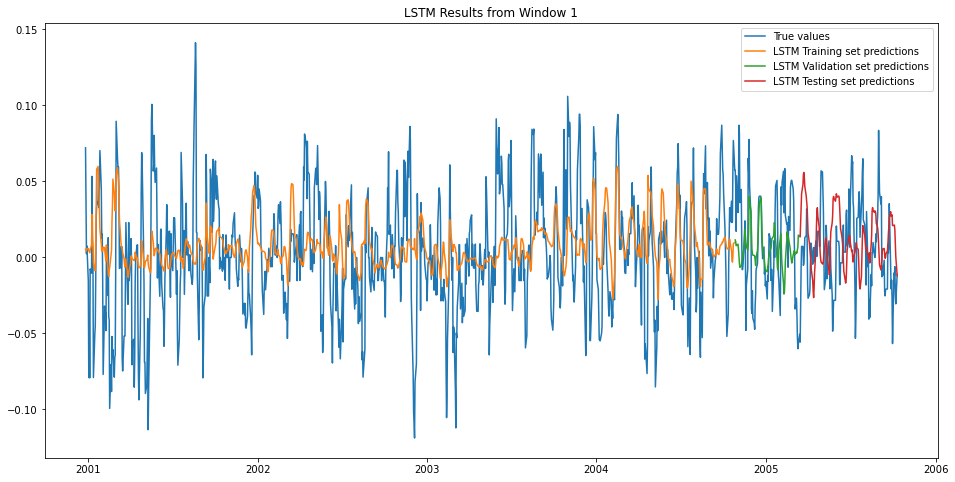

Window 2: 
Training datapoints: 150 - 1149
Validation datapoints: 1150 - 1249
Testing datapoints: 1250 - 1399

Results on Training set: 
MSE = 0.0012680920055660003
RMSE = 0.03561027949294979
MAE = 0.027577970741173602
R-Squared = -0.0011391469096839746

Results on Validation set: 
MSE = 0.0008287849711457608
RMSE = 0.028788625725201973
MAE = 0.02286084390274296
R-Squared = -0.006214891604340966

Results on Testing set: 
MSE = 0.00126941085771549
RMSE = 0.03562879253799503
MAE = 0.026439553799880968
R-Squared = -0.10002879006680443



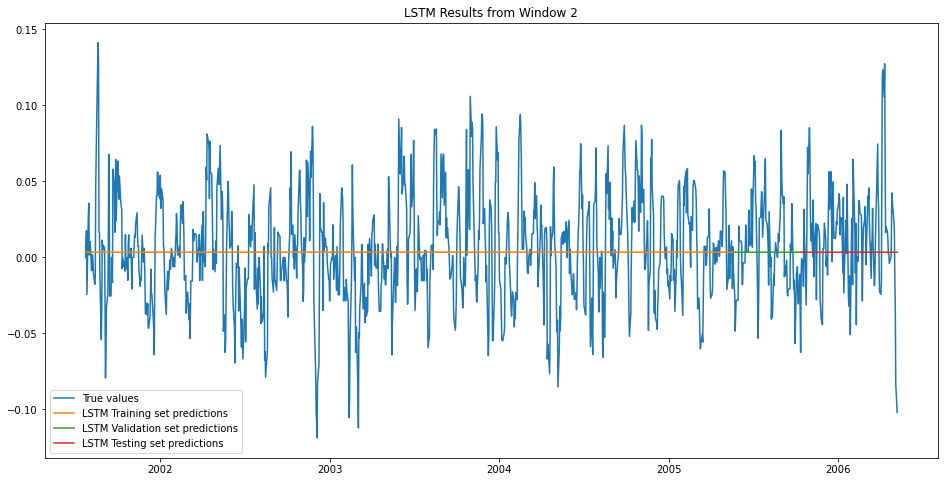

Window 3: 
Training datapoints: 300 - 1299
Validation datapoints: 1300 - 1399
Testing datapoints: 1400 - 1549

Results on Training set: 
MSE = 0.001257164523693316
RMSE = 0.03545651595536871
MAE = 0.027888733240127684
R-Squared = -0.014631671930706691

Results on Validation set: 
MSE = 0.0012825505882695931
RMSE = 0.03581271545512282
MAE = 0.025495722423980825
R-Squared = -0.0331850512837224

Results on Testing set: 
MSE = 0.0017944760858801434
RMSE = 0.04236125689684082
MAE = 0.031367271197400313
R-Squared = -0.012486989119985914



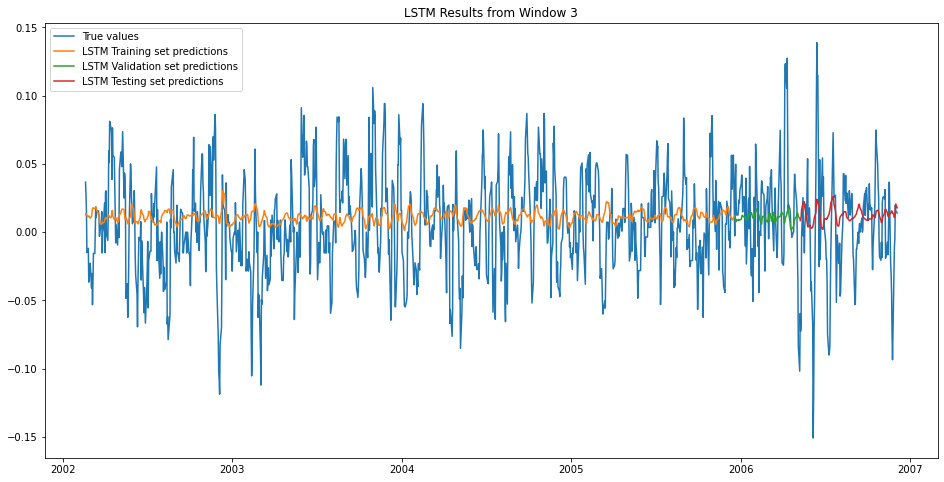

Window 4: 
Training datapoints: 450 - 1449
Validation datapoints: 1450 - 1549
Testing datapoints: 1550 - 1699

Results on Training set: 
MSE = 0.0009191758229149736
RMSE = 0.030317912575158826
MAE = 0.022853093438406465
R-Squared = 0.32893822564607234

Results on Validation set: 
MSE = 0.0007092698250044343
RMSE = 0.026632120174789584
MAE = 0.021026924222165837
R-Squared = 0.2044244053650346

Results on Testing set: 
MSE = 0.0010682104985855736
RMSE = 0.032683489694118856
MAE = 0.02659239167811073
R-Squared = -0.41113084512579756



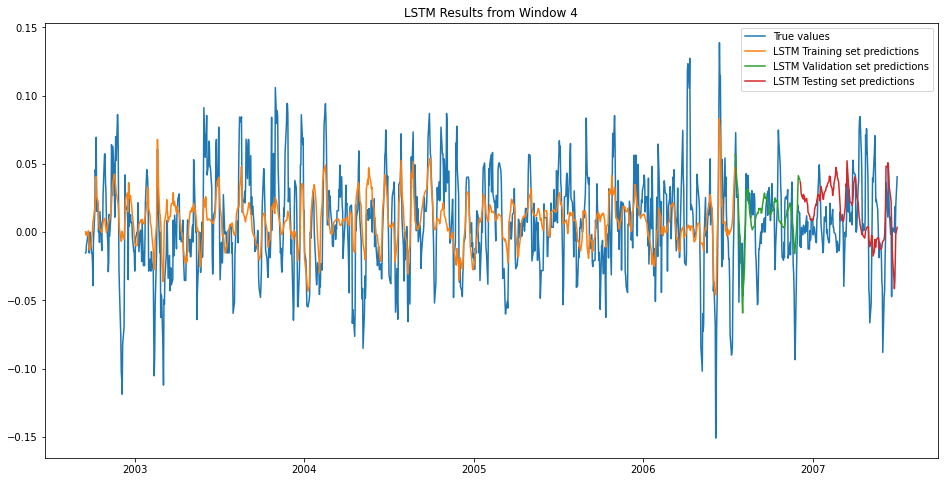

Window 5: 
Training datapoints: 600 - 1599
Validation datapoints: 1600 - 1699
Testing datapoints: 1700 - 1849

Results on Training set: 
MSE = 0.0010975877256834989
RMSE = 0.03312986154036112
MAE = 0.02517754540393635
R-Squared = 0.10884926144175044

Results on Validation set: 
MSE = 0.0008434265956752138
RMSE = 0.029041807720512403
MAE = 0.02168343529415739
R-Squared = 0.18608064747158615

Results on Testing set: 
MSE = 0.0019614953038745793
RMSE = 0.044288771758478236
MAE = 0.03426111725010999
R-Squared = -0.07256947523296642



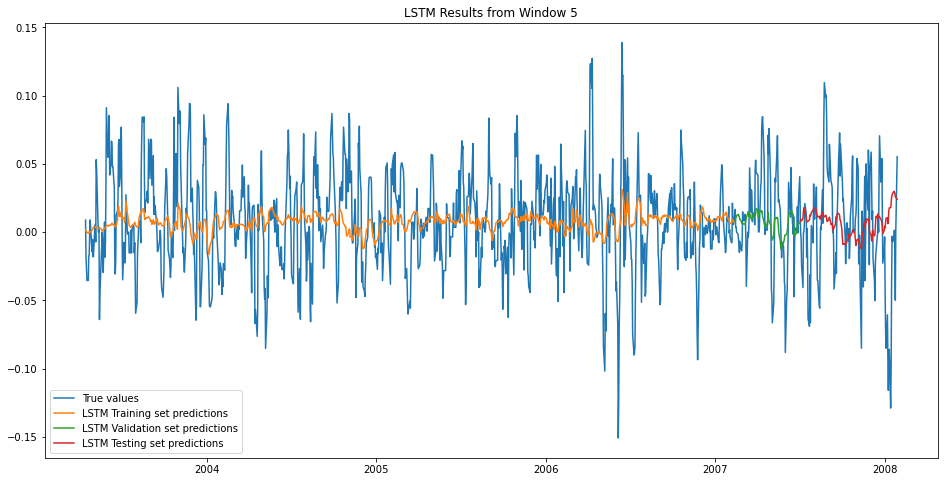

Window 6: 
Training datapoints: 750 - 1749
Validation datapoints: 1750 - 1849
Testing datapoints: 1850 - 1999

Results on Training set: 
MSE = 0.001132394270613505
RMSE = 0.03365106641123733
MAE = 0.025516387408782967
R-Squared = 0.07383595685229427

Results on Validation set: 
MSE = 0.0018471085978670767
RMSE = 0.042978001324713515
MAE = 0.03198242152201149
R-Squared = -0.034473081254301485

Results on Testing set: 
MSE = 0.002103643486989613
RMSE = 0.045865493423592564
MAE = 0.036708008362658
R-Squared = -0.022388281992533843



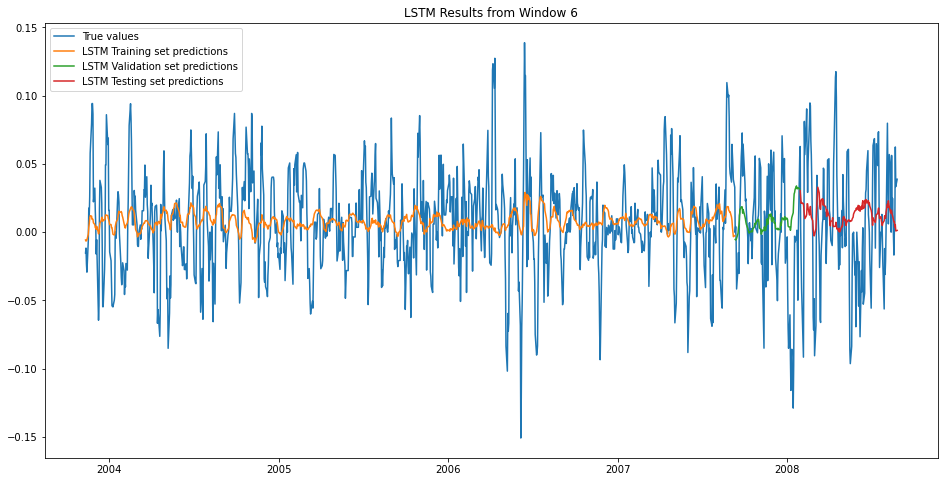

Window 7: 
Training datapoints: 900 - 1899
Validation datapoints: 1900 - 1999
Testing datapoints: 2000 - 2149

Results on Training set: 
MSE = 0.000882471290771963
RMSE = 0.02970641834304437
MAE = 0.022030239269162664
R-Squared = 0.3320870419127314

Results on Validation set: 
MSE = 0.0014431640866500025
RMSE = 0.037988999547895475
MAE = 0.030672761705112742
R-Squared = 0.20512321063612904

Results on Testing set: 
MSE = 0.0025187920461674012
RMSE = 0.05018756864172044
MAE = 0.041367767869455556
R-Squared = -0.11233008669234157



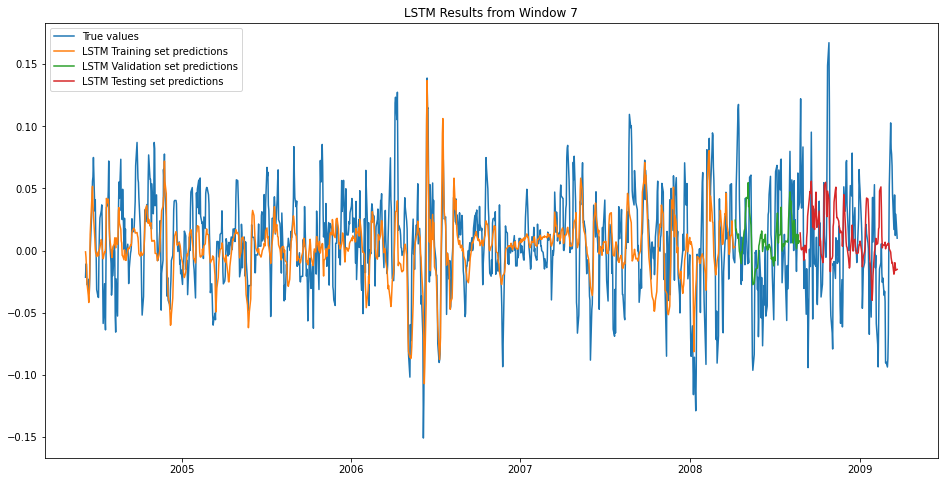

Window 8: 
Training datapoints: 1050 - 2049
Validation datapoints: 2050 - 2149
Testing datapoints: 2150 - 2299

Results on Training set: 
MSE = 0.001561261346102203
RMSE = 0.03951279977554366
MAE = 0.029147085096369835
R-Squared = -0.06680856338462471

Results on Validation set: 
MSE = 0.0016427803295180471
RMSE = 0.040531226597748646
MAE = 0.03171577607083792
R-Squared = 0.111092808453638

Results on Testing set: 
MSE = 0.0008605778172457375
RMSE = 0.029335606645265366
MAE = 0.02323256397893226
R-Squared = -0.07595139239832194



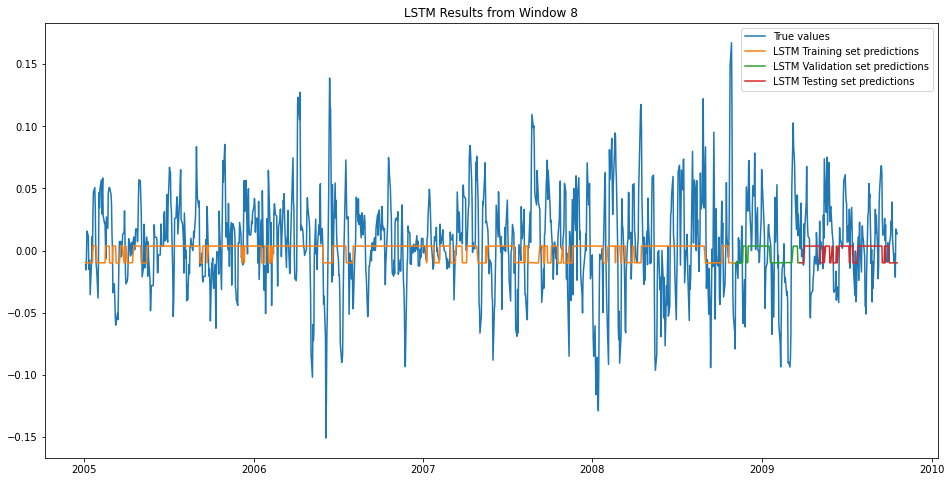

Window 9: 
Training datapoints: 1200 - 2199
Validation datapoints: 2200 - 2299
Testing datapoints: 2300 - 2449

Results on Training set: 
MSE = 0.0014164951645395934
RMSE = 0.0376363542939482
MAE = 0.02802574542257208
R-Squared = 0.10040061465765437

Results on Validation set: 
MSE = 0.000710639284167778
RMSE = 0.02665781844352193
MAE = 0.02081851140689519
R-Squared = 0.049572693666459555

Results on Testing set: 
MSE = 0.0008129238977965528
RMSE = 0.02851182031713431
MAE = 0.022099116098338308
R-Squared = 0.014474783978472794



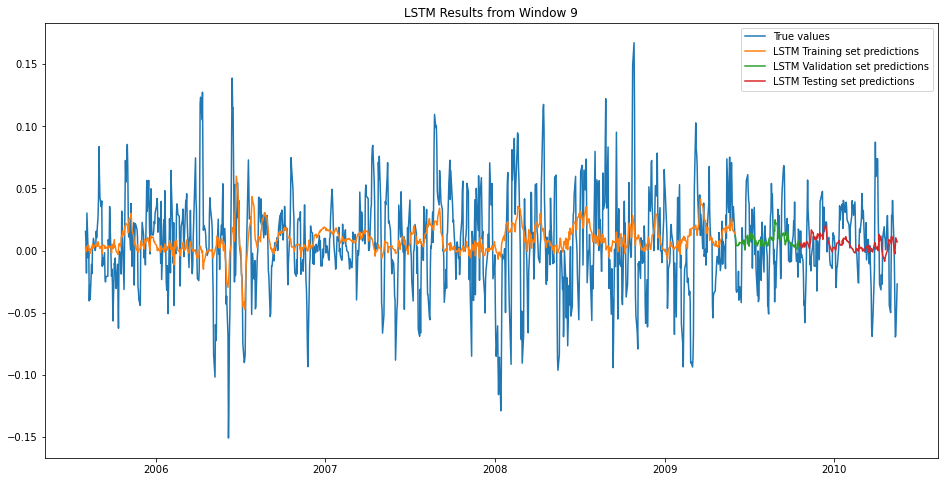

Window 10: 
Training datapoints: 1350 - 2349
Validation datapoints: 2350 - 2449
Testing datapoints: 2450 - 2599

Results on Training set: 
MSE = 0.0003448790535336885
RMSE = 0.018570919566184344
MAE = 0.013522070878581314
R-Squared = 0.7784610486731438

Results on Validation set: 
MSE = 0.0008980546556109198
RMSE = 0.02996756005434743
MAE = 0.02268685541555628
R-Squared = 0.06265969965951967

Results on Testing set: 
MSE = 0.001725151815634995
RMSE = 0.041534946919852864
MAE = 0.035273102230764346
R-Squared = -0.7780119028706594



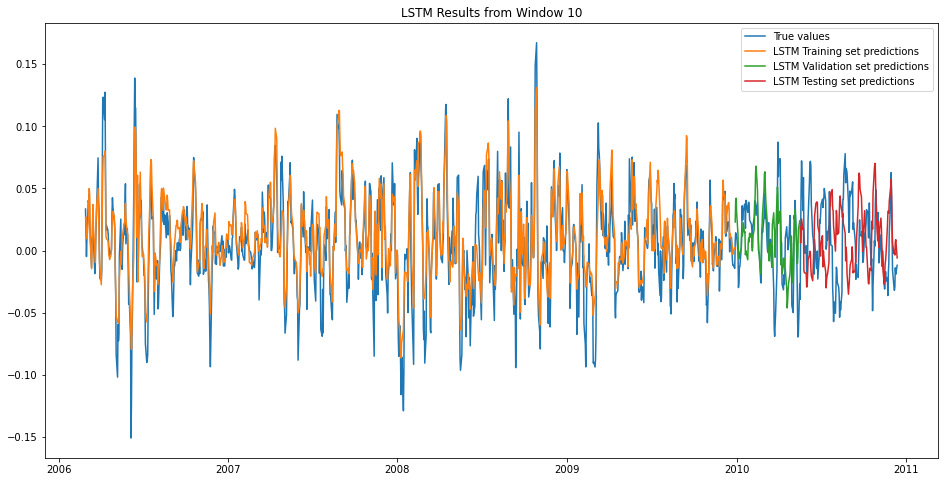

Window 11: 
Training datapoints: 1500 - 2499
Validation datapoints: 2500 - 2599
Testing datapoints: 2600 - 2749

Results on Training set: 
MSE = 0.0011132050500419993
RMSE = 0.03336472763326563
MAE = 0.02465975205197491
R-Squared = 0.19215875929649096

Results on Validation set: 
MSE = 0.0009000583355630315
RMSE = 0.030000972243629565
MAE = 0.024855089154553537
R-Squared = 0.10735647420398886

Results on Testing set: 
MSE = 0.0010312209259258427
RMSE = 0.03211262876075147
MAE = 0.02619030866817848
R-Squared = -0.3056016772894308



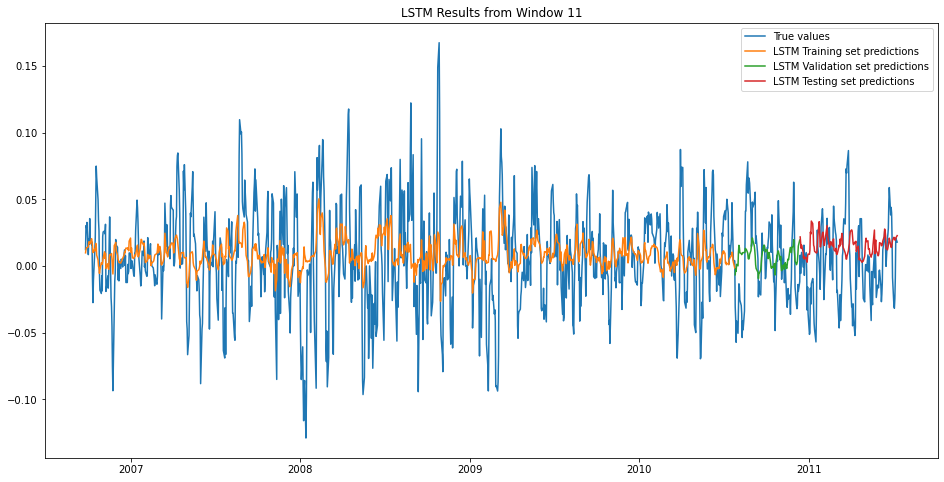

Window 12: 
Training datapoints: 1650 - 2649
Validation datapoints: 2650 - 2749
Testing datapoints: 2750 - 2899

Results on Training set: 
MSE = 0.0013829360240918893
RMSE = 0.037187847801289725
MAE = 0.02843816040547611
R-Squared = 0.023983661492161468

Results on Validation set: 
MSE = 0.0008588499196502447
RMSE = 0.029306141329937054
MAE = 0.023736564408029764
R-Squared = 0.02176992477331574

Results on Testing set: 
MSE = 0.0010295932547400974
RMSE = 0.032087275589244055
MAE = 0.02402524407469681
R-Squared = -0.049710855095906004



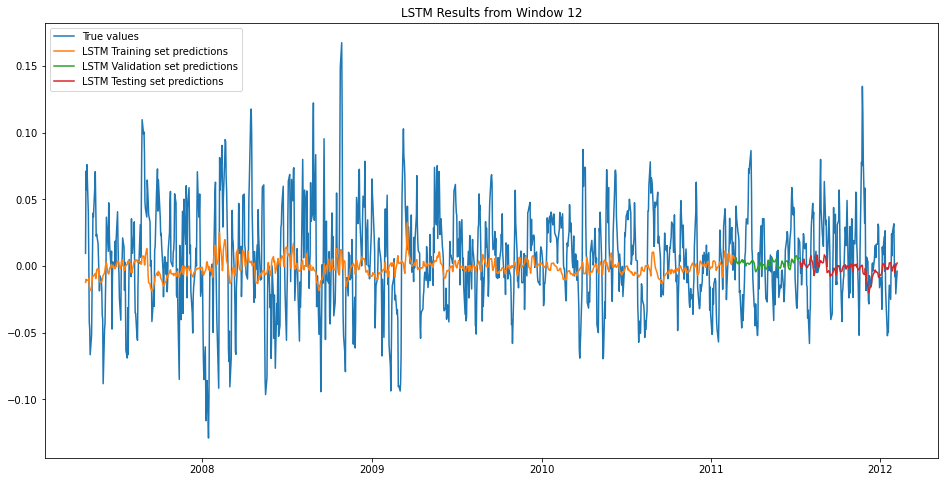

Window 13: 
Training datapoints: 1800 - 2799
Validation datapoints: 2800 - 2899
Testing datapoints: 2900 - 3049

Results on Training set: 
MSE = 0.00048084883442109616
RMSE = 0.021928265650094085
MAE = 0.01635928198568979
R-Squared = 0.6405356166752217

Results on Validation set: 
MSE = 0.0008820973934358786
RMSE = 0.02970012446835667
MAE = 0.02162031729127404
R-Squared = 0.16385436321511704

Results on Testing set: 
MSE = 0.0012548466034178402
RMSE = 0.035423814072144184
MAE = 0.028450202620019068
R-Squared = -0.5288007640621515



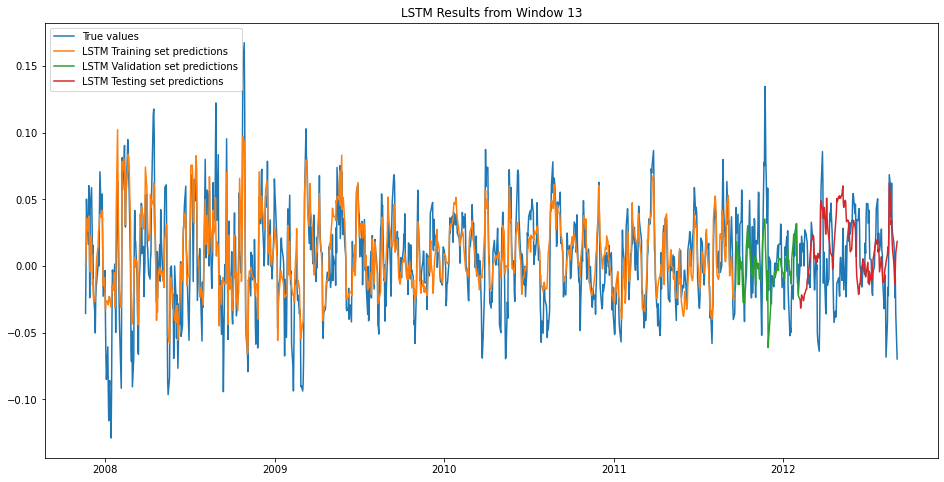

Window 14: 
Training datapoints: 1950 - 2949
Validation datapoints: 2950 - 3049
Testing datapoints: 3050 - 3199

Results on Training set: 
MSE = 0.000865851110103204
RMSE = 0.029425348088055032
MAE = 0.0221105457322083
R-Squared = 0.21722999323734915

Results on Validation set: 
MSE = 0.0007975499403225952
RMSE = 0.028240926690223805
MAE = 0.023039721008248835
R-Squared = 0.011887160209733683

Results on Testing set: 
MSE = 0.001553958691085878
RMSE = 0.039420282737264556
MAE = 0.03065436763224233
R-Squared = -0.22112948280210332



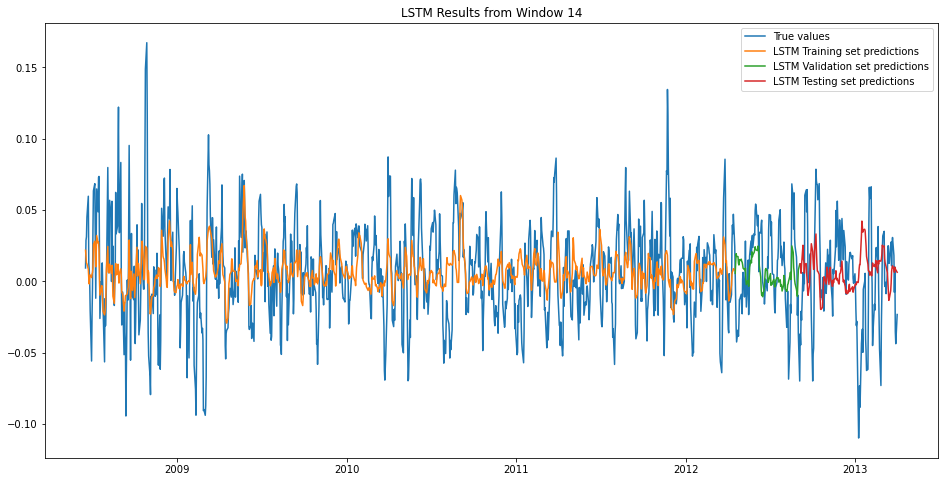

Window 15: 
Training datapoints: 2100 - 3099
Validation datapoints: 3100 - 3199
Testing datapoints: 3200 - 3349

Results on Training set: 
MSE = 0.0009445604638641989
RMSE = 0.030733702410614294
MAE = 0.02400812807298545
R-Squared = 0.02607595474849611

Results on Validation set: 
MSE = 0.001365208302439888
RMSE = 0.03694872531549482
MAE = 0.028719198241314175
R-Squared = -0.08050508337918938

Results on Testing set: 
MSE = 0.0012701088503795114
RMSE = 0.035638586537340554
MAE = 0.02680442193789388
R-Squared = -0.01933071232346295



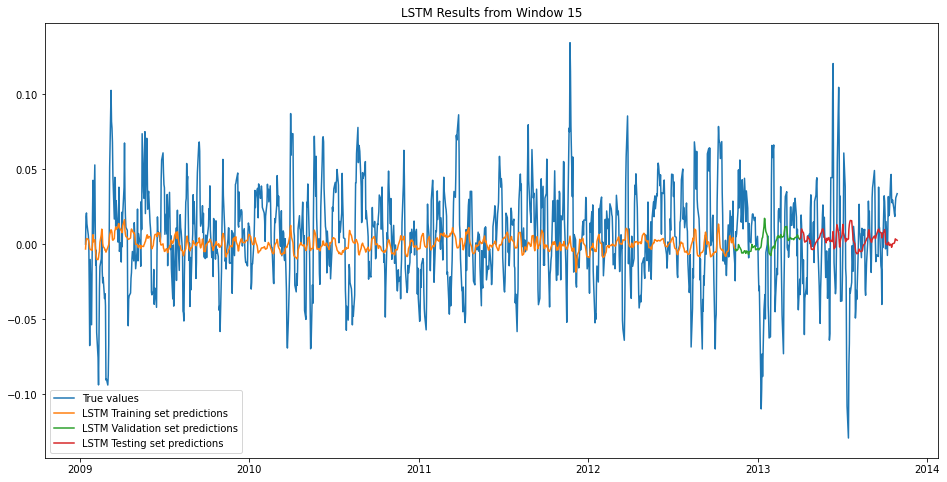

Window 16: 
Training datapoints: 2250 - 3249
Validation datapoints: 3250 - 3349
Testing datapoints: 3350 - 3499

Results on Training set: 
MSE = 0.000927115735306668
RMSE = 0.03044857525906045
MAE = 0.02369005126927584
R-Squared = 0.01624603300963634

Results on Validation set: 
MSE = 0.0013638178284245354
RMSE = 0.036929904256909944
MAE = 0.026714894609941742
R-Squared = 0.04996038934014524

Results on Testing set: 
MSE = 0.001158306337648443
RMSE = 0.03403389983014646
MAE = 0.02717373841829603
R-Squared = -0.22172862469759713



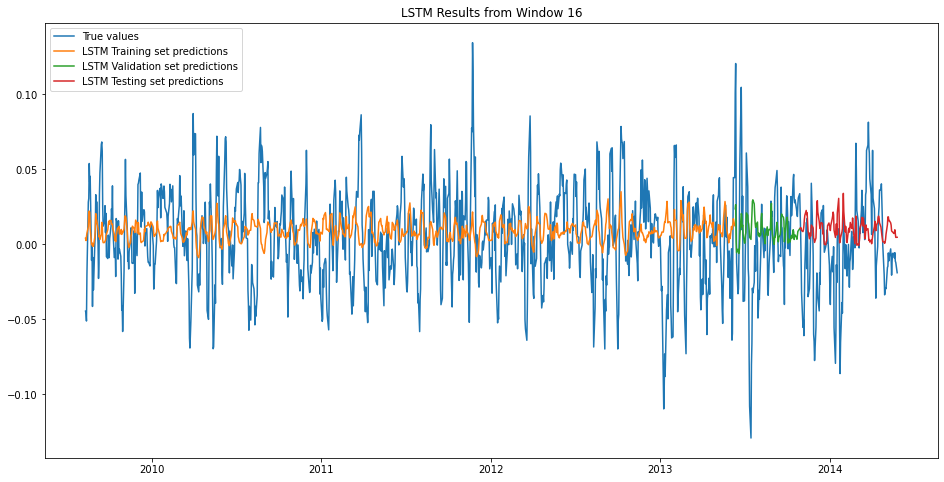

Window 17: 
Training datapoints: 2400 - 3399
Validation datapoints: 3400 - 3499
Testing datapoints: 3500 - 3649

Results on Training set: 
MSE = 0.0010013291625673051
RMSE = 0.03164378552839886
MAE = 0.02438407336697673
R-Squared = 0.04122475150506155

Results on Validation set: 
MSE = 0.000874513056352609
RMSE = 0.029572166920139774
MAE = 0.022900023747711384
R-Squared = 0.10811863612322803

Results on Testing set: 
MSE = 0.0017192361561464368
RMSE = 0.04146367272862399
MAE = 0.03157896440795439
R-Squared = -0.13120169479564425



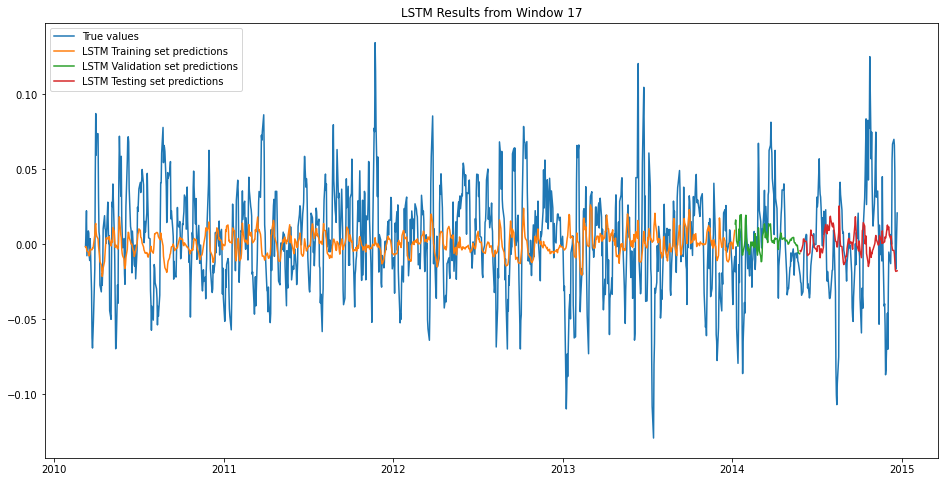

Window 18: 
Training datapoints: 2550 - 3549
Validation datapoints: 3550 - 3649
Testing datapoints: 3650 - 3799

Results on Training set: 
MSE = 0.0008855934776033264
RMSE = 0.029758922655286537
MAE = 0.02247010467427616
R-Squared = 0.10243799350305294

Results on Validation set: 
MSE = 0.0018706905330714164
RMSE = 0.04325148012578779
MAE = 0.03315269054556896
R-Squared = 0.0610443712026395

Results on Testing set: 
MSE = 0.0008630570327658148
RMSE = 0.02937783233606276
MAE = 0.02369774709905003
R-Squared = 0.07001727844460037



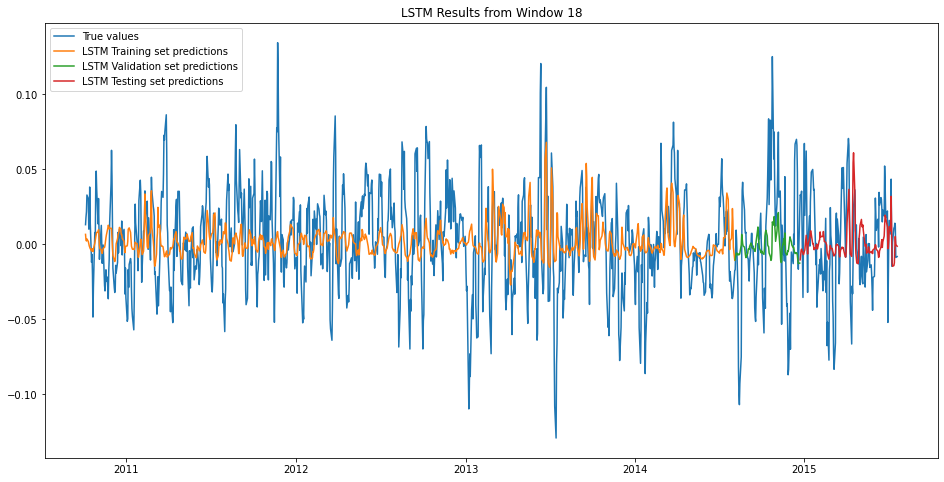

Window 19: 
Training datapoints: 2700 - 3699
Validation datapoints: 3700 - 3799
Testing datapoints: 3800 - 3949

Results on Training set: 
MSE = 0.0008180851354631011
RMSE = 0.02860218759925718
MAE = 0.021065965533067128
R-Squared = 0.2648922839028416

Results on Validation set: 
MSE = 0.00059255024459435
RMSE = 0.02434235495169582
MAE = 0.01811911196143702
R-Squared = 0.30770775696391006

Results on Testing set: 
MSE = 0.0019033340571472327
RMSE = 0.04362721693103094
MAE = 0.03542964285420066
R-Squared = -0.36495586511695777



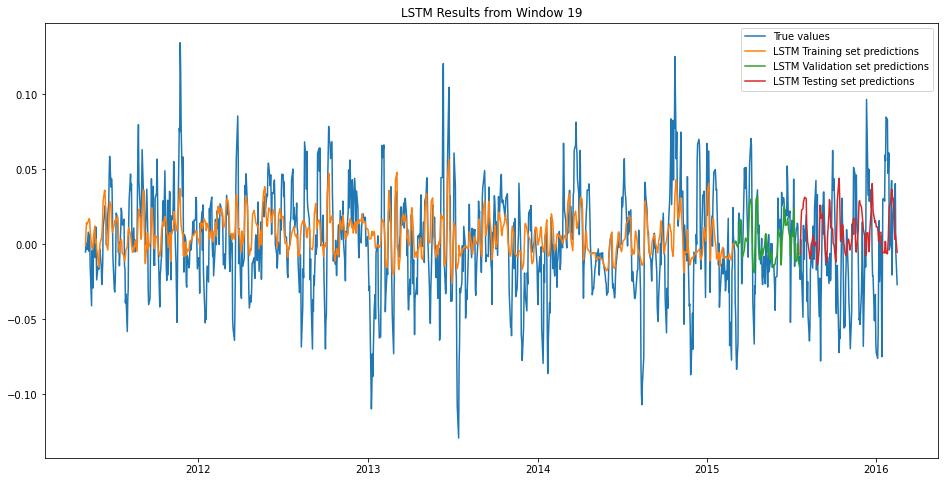

Window 20: 
Training datapoints: 2850 - 3849
Validation datapoints: 3850 - 3949
Testing datapoints: 3950 - 4099

Results on Training set: 
MSE = 0.0011439300711214774
RMSE = 0.03382203528946
MAE = 0.026171444483384945
R-Squared = -0.051610601868592676

Results on Validation set: 
MSE = 0.001835417569483587
RMSE = 0.04284177365006714
MAE = 0.03594452347778318
R-Squared = -0.07244556560495252

Results on Testing set: 
MSE = 0.002098515796121744
RMSE = 0.04580956009526553
MAE = 0.03445060786423031
R-Squared = -0.22891076788792564



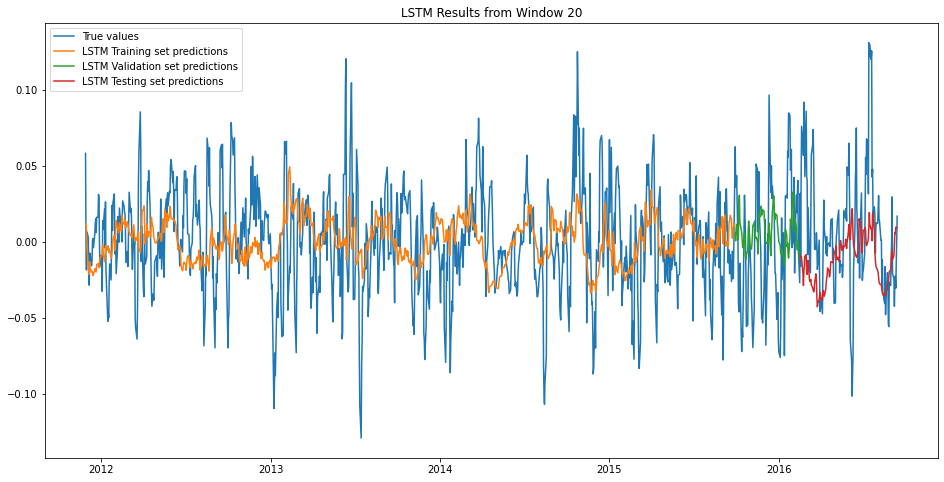

Window 21: 
Training datapoints: 3000 - 3999
Validation datapoints: 4000 - 4099
Testing datapoints: 4100 - 4249

Results on Training set: 
MSE = 0.0011882431933814674
RMSE = 0.034470903576516054
MAE = 0.026589715663821917
R-Squared = 0.03171117499211873

Results on Validation set: 
MSE = 0.0017902892250111681
RMSE = 0.04231180952182462
MAE = 0.028999934574172846
R-Squared = 0.06078525750458341

Results on Testing set: 
MSE = 0.0015409388388346094
RMSE = 0.03925479383253222
MAE = 0.030781997631825302
R-Squared = -0.06622691270948566



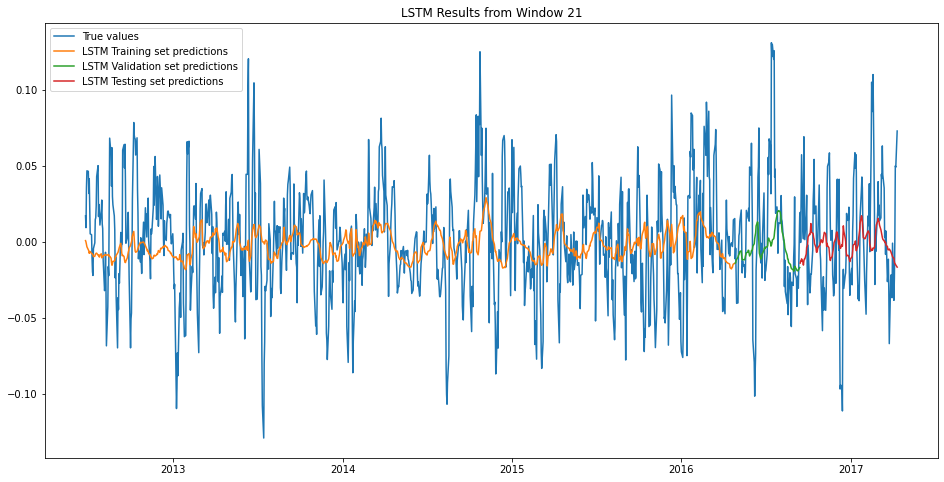

Window 22: 
Training datapoints: 3150 - 4149
Validation datapoints: 4150 - 4249
Testing datapoints: 4250 - 4399

Results on Training set: 
MSE = 0.0011079022627720812
RMSE = 0.03328516580658839
MAE = 0.02485364967953038
R-Squared = 0.1324880583884499

Results on Validation set: 
MSE = 0.0015761096804555708
RMSE = 0.039700247863905976
MAE = 0.02972036650917469
R-Squared = 0.07483629412156678

Results on Testing set: 
MSE = 0.0013139612792008573
RMSE = 0.036248603824159314
MAE = 0.02765669898117163
R-Squared = -0.29361183946887937



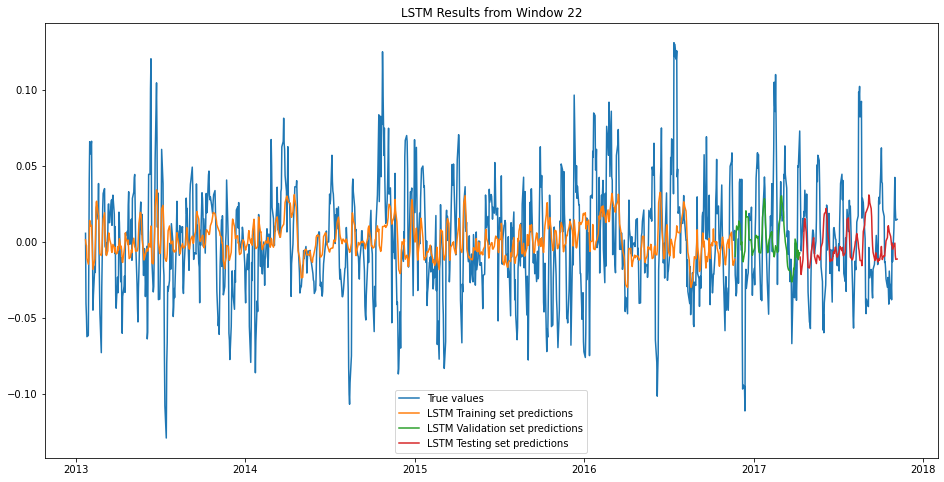

Window 23: 
Training datapoints: 3300 - 4299
Validation datapoints: 4300 - 4399
Testing datapoints: 4400 - 4549

Results on Training set: 
MSE = 0.001227829682484776
RMSE = 0.03504040071809648
MAE = 0.027026583460495367
R-Squared = 0.04389445426678362

Results on Validation set: 
MSE = 0.0010333803278306571
RMSE = 0.032146233493687205
MAE = 0.024196172416539142
R-Squared = 0.029440961238684893

Results on Testing set: 
MSE = 0.0017270916475286158
RMSE = 0.04155829216328091
MAE = 0.03119007884143746
R-Squared = -0.01457186831347057



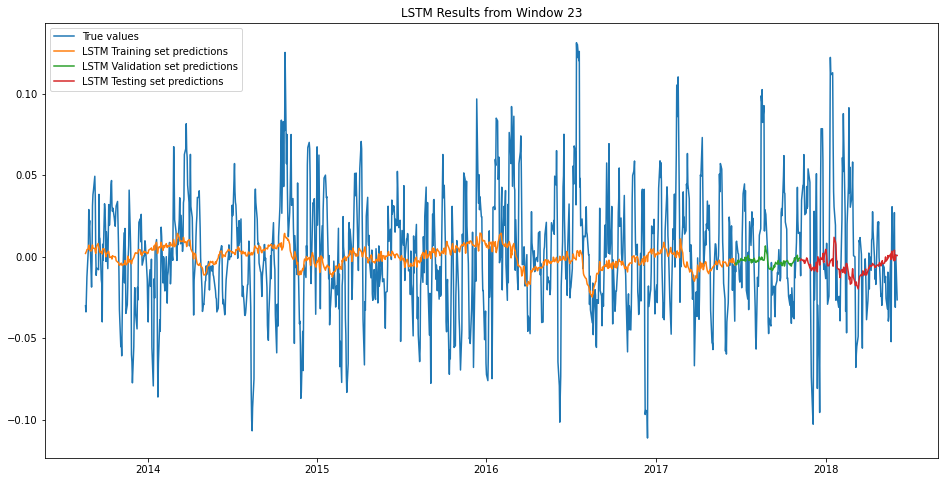

Window 24: 
Training datapoints: 3450 - 4449
Validation datapoints: 4450 - 4549
Testing datapoints: 4550 - 4699

Results on Training set: 
MSE = 0.0013158271870210324
RMSE = 0.036274332344249045
MAE = 0.027729685575402563
R-Squared = 0.0616603074358647

Results on Validation set: 
MSE = 0.0011554058223208798
RMSE = 0.03399126096985635
MAE = 0.025403874220217552
R-Squared = -0.0040647721246904744

Results on Testing set: 
MSE = 0.0014726883261403096
RMSE = 0.03837562150819592
MAE = 0.03087518785011761
R-Squared = -0.06223003554170292



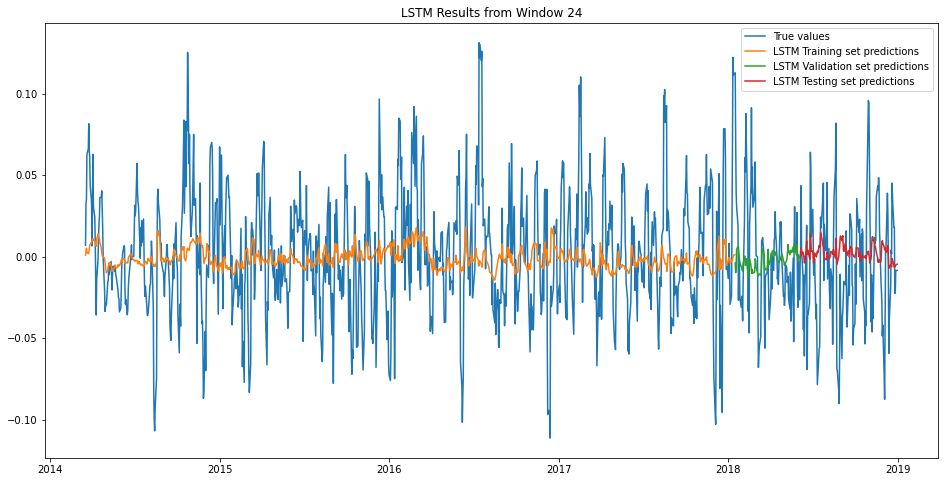

Window 25: 
Training datapoints: 3600 - 4599
Validation datapoints: 4600 - 4699
Testing datapoints: 4700 - 4955

Results on Training set: 
MSE = 0.0013868081512985338
RMSE = 0.03723987313751933
MAE = 0.028179396606723466
R-Squared = 0.02978801928699526

Results on Validation set: 
MSE = 0.0014052350033262133
RMSE = 0.037486464268135684
MAE = 0.030411420541327283
R-Squared = 0.07155377510750427

Results on Testing set: 
MSE = 0.002879974088485708
RMSE = 0.053665390043171286
MAE = 0.040573121244561944
R-Squared = -0.07634690911099051



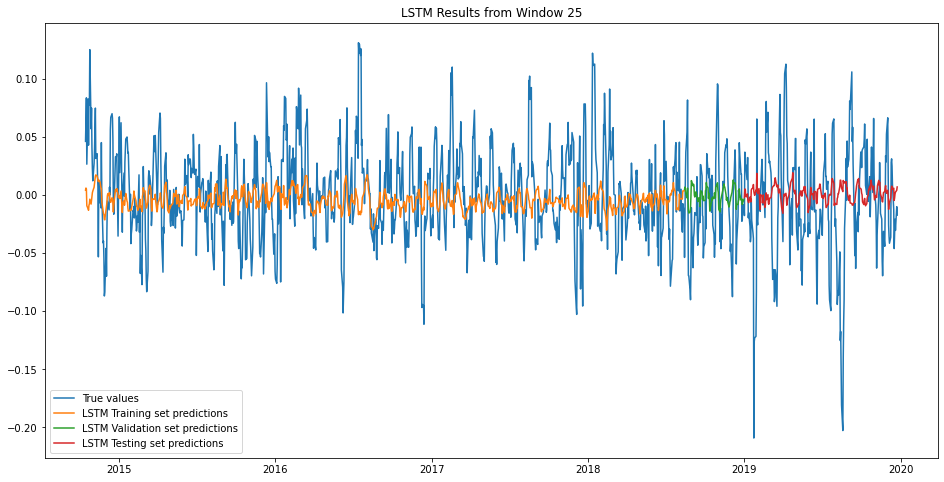

In [7]:
dataset = df.values
totaldatapoints = len(dataset)

#Declaring model parameters
sequencelength = 163
features = len(df.columns) - 1
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength
lstm_predictions = np.zeros((numPredictions + extra,1)) 
lstm_target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra

  #Print window information
  windowInfo(w, sequencelength, start, trainingSize, validationSize, end)
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #Create, train and test LSTM
  lstm_model = create_lstm()
  lstm_history, lstm_model = train_lstm(lstm_model, x_train, y_train, x_val, y_val)
  lstm_predictions, lstm_trainingPredictions, lstm_valPredictions, lstm_testingPredictions = makePredictions(lstm_model, lstm_predictions, x_train, x_val, x_test)
  evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, lstm_trainingPredictions, lstm_valPredictions, lstm_testingPredictions)

  lstm_target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Plot graph of forecasts
  trainGraph = pd.DataFrame(df[start : start + trainingSize])
  trainGraph['LSTM Train Predictions'] = lstm_trainingPredictions
  valGraph = pd.DataFrame(df[start + trainingSize : end - testingSize])
  valGraph['LSTM Val Predictions'] = lstm_valPredictions
  testGraph = pd.DataFrame(df[start + trainingSize + validationSize : end])
  testGraph['LSTM Test Predictions'] = lstm_testingPredictions

  #Plot LSTM Results
  plt.figure(figsize=(16,8))
  plt.plot(df['Target'][start : end], label='True values')
  plt.plot(trainGraph['LSTM Train Predictions'], label = 'LSTM Training set predictions')
  plt.plot(valGraph['LSTM Val Predictions'], label = 'LSTM Validation set predictions')
  plt.plot(testGraph['LSTM Test Predictions'], label = 'LSTM Testing set predictions')
  plt.title("LSTM Results from Window " + str(w + 1))
  plt.legend(loc = 'best')
  plt.show()

  #Update window parameters
  start += testingSize
  end += testingSize

In [8]:
K.clear_session()
tf.compat.v1.reset_default_graph()

**GRU model**

In [9]:
def create_gru():
  '''
  Function to create an GRU using the Keras Framework
  @returns
    model - Compiled GRU
  '''
  #hyperparameters
  learningRate = 0.007728660995947853
  dropout =  0.14236920456351018
  units = 89

  #Construct GRU
  model = Sequential()
  model.add(GRU(units=units, return_sequences=True, input_shape=(sequencelength, features)))
  model.add(GRU(units=units, dropout=dropout))
  model.add(Dense(1))

  #GRU compile
  ao = Adam(lr=learningRate, amsgrad=True)
  model.compile(loss='mae', optimizer=ao, metrics=['mse','mae', 'mape', 'msle'])

  return model

def train_gru(model, x_train, y_train, x_val, y_val):
  '''
  Function to train the LSTM
  @params:
    model - Keras LSTM model
    x_train - Training Input
    y_train - Training Output
    x_val - Validation Input
    y_val - Validation Output
  @returns:
    history - Model history
    model - Best model according to early stopping
  '''
  batchSize = 198
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
  mc = ModelCheckpoint('./GRU.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
  history = model.fit(x_train, y_train, epochs=150, batch_size=batchSize, verbose=0, validation_data = (x_val, y_val), callbacks=[es, mc])
  model = load_model('./GRU.h5')
  return history, model

**GRU Forecasting Implementation**

Window 1: 
Training datapoints: 0 - 999
Validation datapoints: 1000 - 1099
Testing datapoints: 1100 - 1249

Results on Training set: 
MSE = 0.0014676409360682762
RMSE = 0.03830980208860751
MAE = 0.02947275823507077
R-Squared = 0.0012109325638550716

Results on Validation set: 
MSE = 0.0008051740583743293
RMSE = 0.028375589128233607
MAE = 0.022450735117807607
R-Squared = -0.028389835789646822

Results on Testing set: 
MSE = 0.0010257199081250867
RMSE = 0.03202686228972621
MAE = 0.024849982504138193
R-Squared = -0.21967830002704858



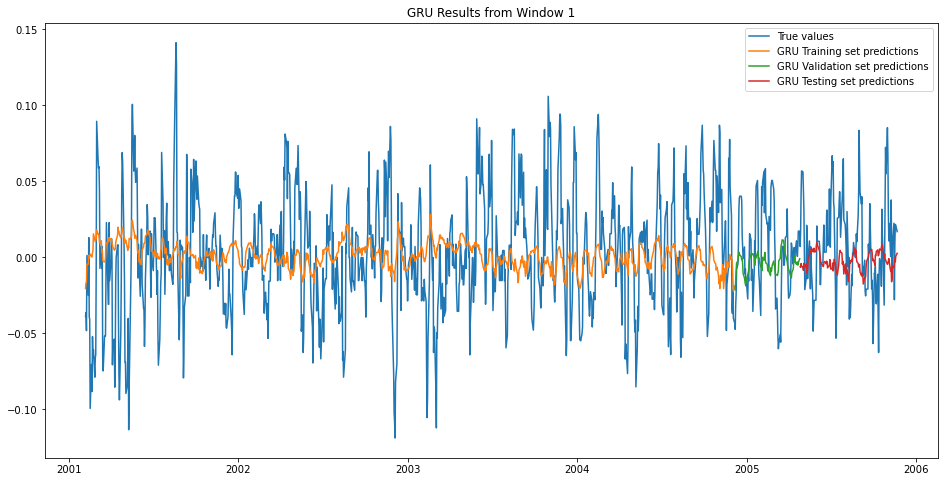

Window 2: 
Training datapoints: 150 - 1149
Validation datapoints: 1150 - 1249
Testing datapoints: 1250 - 1399

Results on Training set: 
MSE = 0.0011560141398781743
RMSE = 0.034000207938749055
MAE = 0.026256960323551053
R-Squared = 0.05909595827543723

Results on Validation set: 
MSE = 0.0009951455700543557
RMSE = 0.03154592794727008
MAE = 0.02504125142764521
R-Squared = -0.03831756002365805

Results on Testing set: 
MSE = 0.0018781022671174926
RMSE = 0.04333707727936314
MAE = 0.031641662829134894
R-Squared = -0.004659483382785323



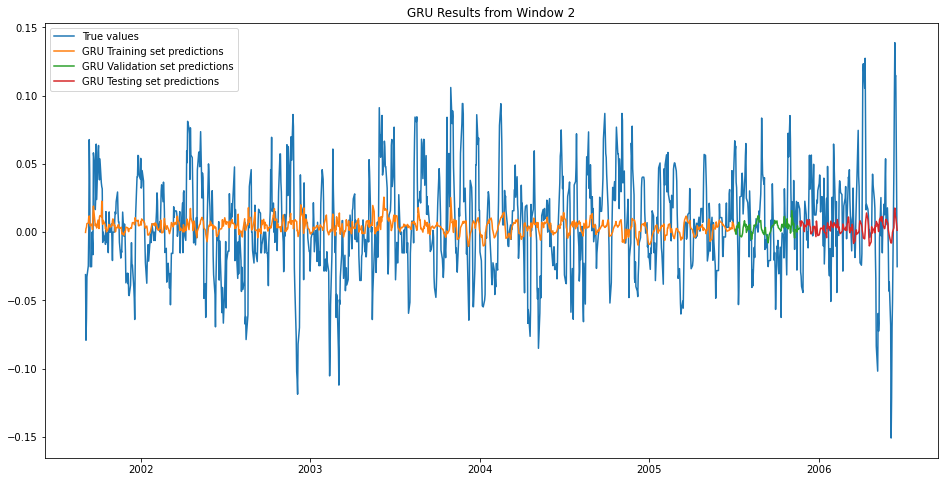

Window 3: 
Training datapoints: 300 - 1299
Validation datapoints: 1300 - 1399
Testing datapoints: 1400 - 1549

Results on Training set: 
MSE = 0.001224950111923171
RMSE = 0.03499928730593198
MAE = 0.027241288056969282
R-Squared = 0.013609693060227301

Results on Validation set: 
MSE = 0.002225951554615504
RMSE = 0.04717999104085867
MAE = 0.03437131291036679
R-Squared = 0.0909695103113809

Results on Testing set: 
MSE = 0.0009974093065267706
RMSE = 0.03158178757649368
MAE = 0.02307187951027394
R-Squared = -0.07587949488639123



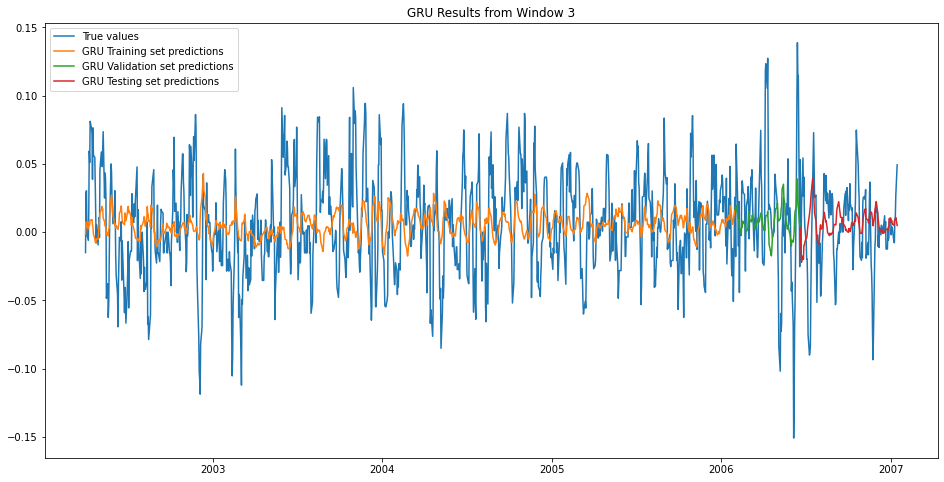

Window 4: 
Training datapoints: 450 - 1449
Validation datapoints: 1450 - 1549
Testing datapoints: 1550 - 1699

Results on Training set: 
MSE = 0.001069095699355613
RMSE = 0.03269702890715934
MAE = 0.025011619299694896
R-Squared = 0.22593038577814417

Results on Validation set: 
MSE = 0.000575830929559363
RMSE = 0.023996477440644554
MAE = 0.01683259952117382
R-Squared = 0.10516845642640182

Results on Testing set: 
MSE = 0.0009018228386974625
RMSE = 0.03003036527745646
MAE = 0.023158650961270278
R-Squared = 0.04753832022591031



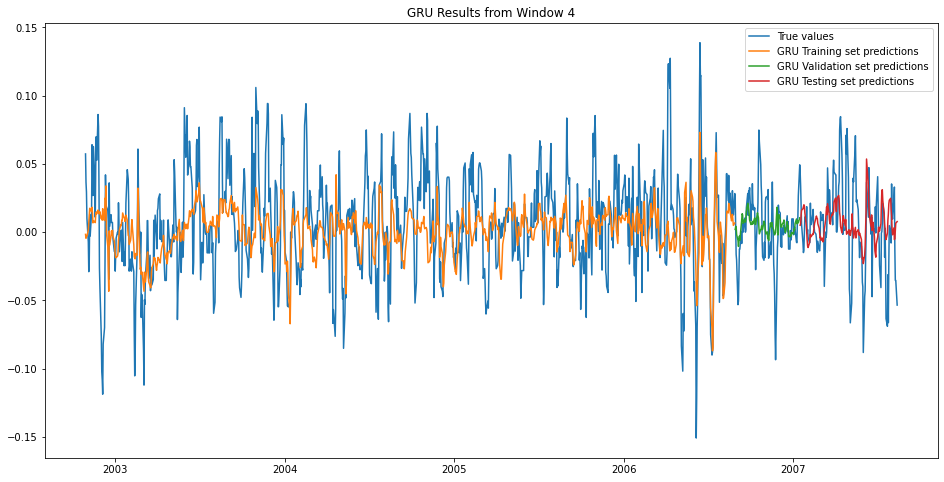

Window 5: 
Training datapoints: 600 - 1599
Validation datapoints: 1600 - 1699
Testing datapoints: 1700 - 1849

Results on Training set: 
MSE = 0.0012046756682856756
RMSE = 0.034708437998355324
MAE = 0.026483521160643526
R-Squared = 0.009336596886331816

Results on Validation set: 
MSE = 0.001133642978747633
RMSE = 0.03366961506681704
MAE = 0.026026212398696628
R-Squared = 0.1285169680264684

Results on Testing set: 
MSE = 0.0024857578435073164
RMSE = 0.049857375016213165
MAE = 0.03927194980795012
R-Squared = -0.06819460278842104



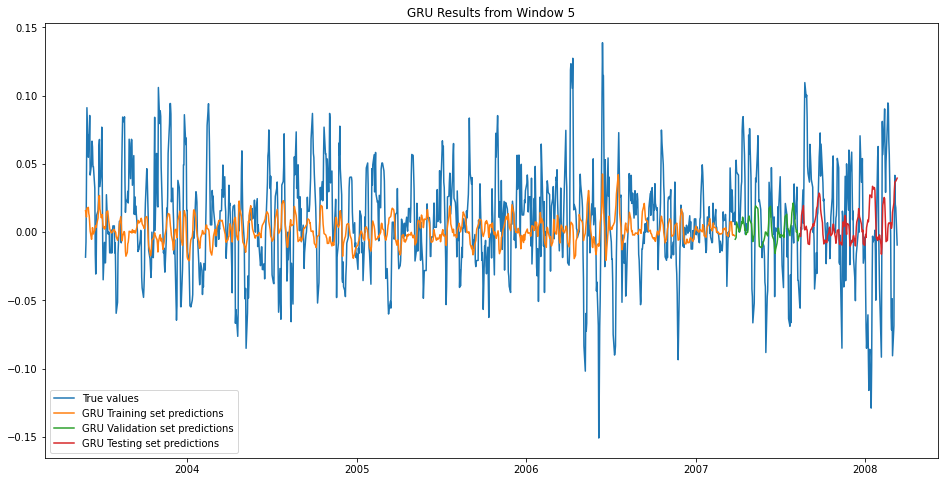

Window 6: 
Training datapoints: 750 - 1749
Validation datapoints: 1750 - 1849
Testing datapoints: 1850 - 1999

Results on Training set: 
MSE = 0.0011118333232860815
RMSE = 0.03334416475616208
MAE = 0.02555095540890558
R-Squared = 0.06599124190318129

Results on Validation set: 
MSE = 0.0025434122185326465
RMSE = 0.05043225375226301
MAE = 0.04080665190216494
R-Squared = 0.02103199972966019

Results on Testing set: 
MSE = 0.0020295187741616997
RMSE = 0.04505018062296421
MAE = 0.0355273095482661
R-Squared = -0.10969244576310833



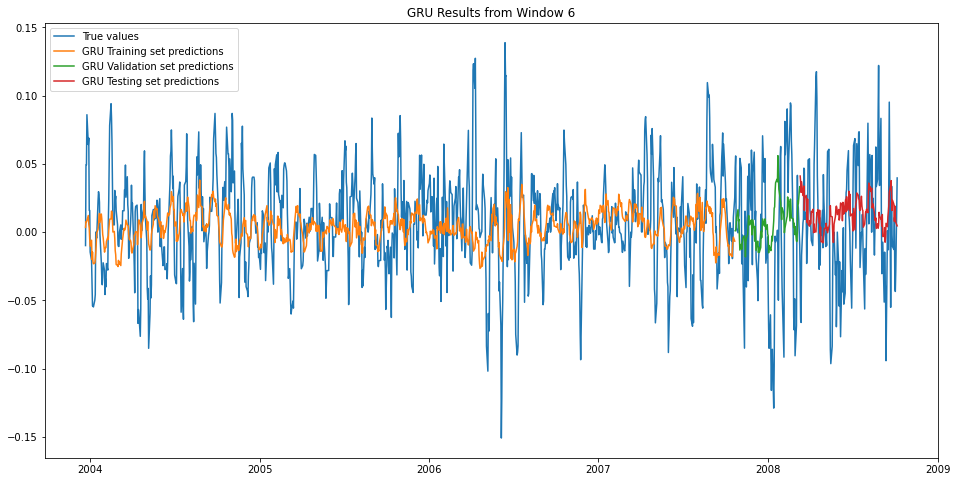

Window 7: 
Training datapoints: 900 - 1899
Validation datapoints: 1900 - 1999
Testing datapoints: 2000 - 2149

Results on Training set: 
MSE = 0.0014468456995252415
RMSE = 0.03803742498546979
MAE = 0.028868067073957043
R-Squared = -0.05864574694119162

Results on Validation set: 
MSE = 0.0015642031983081855
RMSE = 0.03955000882816824
MAE = 0.0316217534502818
R-Squared = 0.09035421320858683

Results on Testing set: 
MSE = 0.0018000722069379956
RMSE = 0.04242725782958399
MAE = 0.03232184397508187
R-Squared = 0.06722338840700459



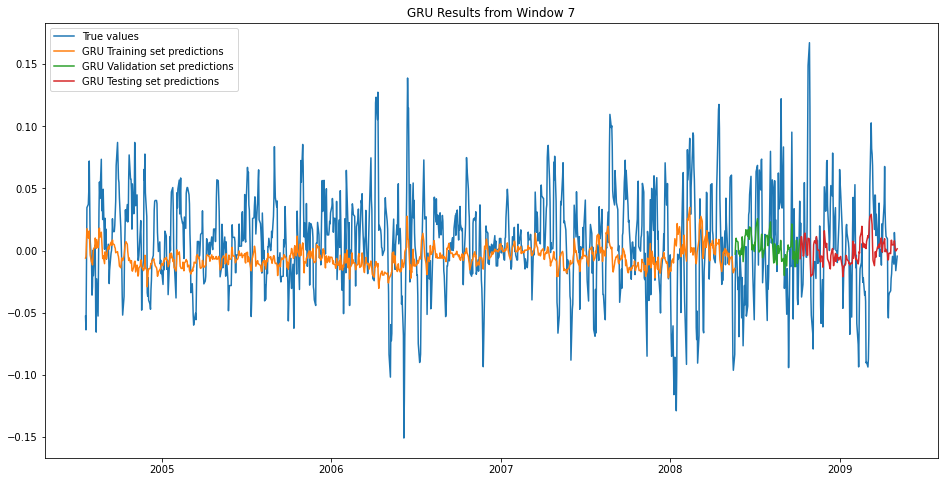

Window 8: 
Training datapoints: 1050 - 2049
Validation datapoints: 2050 - 2149
Testing datapoints: 2150 - 2299

Results on Training set: 
MSE = 0.001240658131377492
RMSE = 0.03522297732130962
MAE = 0.02598442496229069
R-Squared = 0.16263104155762564

Results on Validation set: 
MSE = 0.00154583319818165
RMSE = 0.03931708532154501
MAE = 0.02924283211801502
R-Squared = 0.049121516181129365

Results on Testing set: 
MSE = 0.0007167471405624579
RMSE = 0.026772133657264933
MAE = 0.021319813725623422
R-Squared = 0.0852954041174685



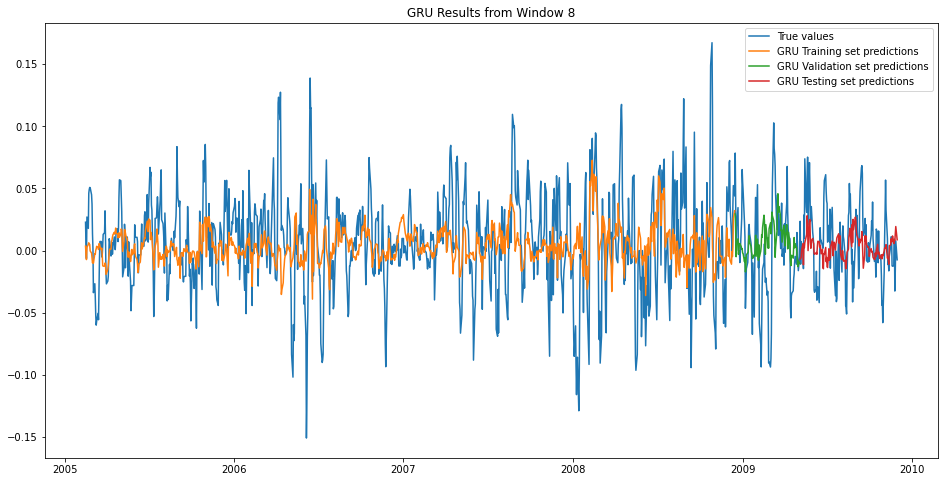

Window 9: 
Training datapoints: 1200 - 2199
Validation datapoints: 2200 - 2299
Testing datapoints: 2300 - 2449

Results on Training set: 
MSE = 0.0014916041513144598
RMSE = 0.03862129142473695
MAE = 0.029022502943220493
R-Squared = 0.054227795401461054

Results on Validation set: 
MSE = 0.0006013838622879893
RMSE = 0.024523129129211656
MAE = 0.019018221973540243
R-Squared = 0.10432176204972554

Results on Testing set: 
MSE = 0.0008410480102336485
RMSE = 0.02900082775083581
MAE = 0.023360908217633508
R-Squared = 0.0671514237791816



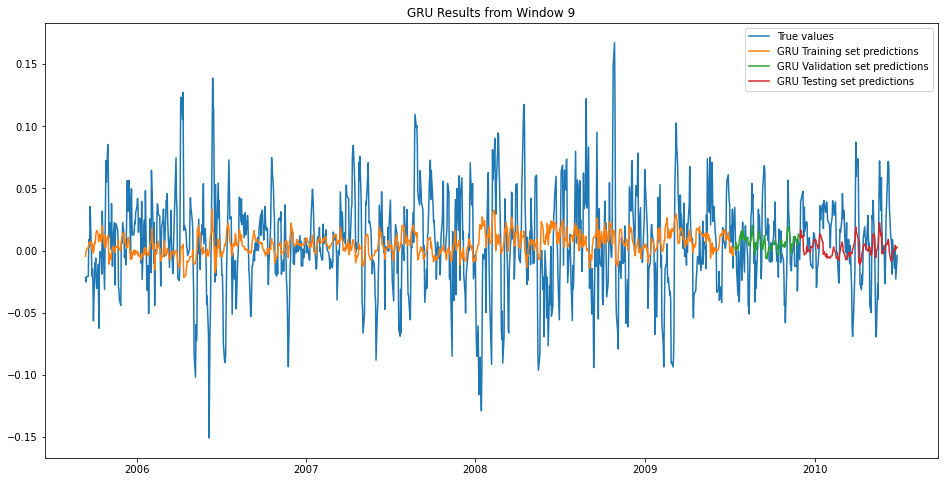

Window 10: 
Training datapoints: 1350 - 2349
Validation datapoints: 2350 - 2449
Testing datapoints: 2450 - 2599

Results on Training set: 
MSE = 0.0014494321477698565
RMSE = 0.03807140853409362
MAE = 0.028385760397893693
R-Squared = 0.04345763559912974

Results on Validation set: 
MSE = 0.0009861379177784815
RMSE = 0.03140283295784763
MAE = 0.023964782013670933
R-Squared = 0.1380126927519879

Results on Testing set: 
MSE = 0.001119770180023858
RMSE = 0.03346296729257371
MAE = 0.027773540267858998
R-Squared = -0.20658946578476733



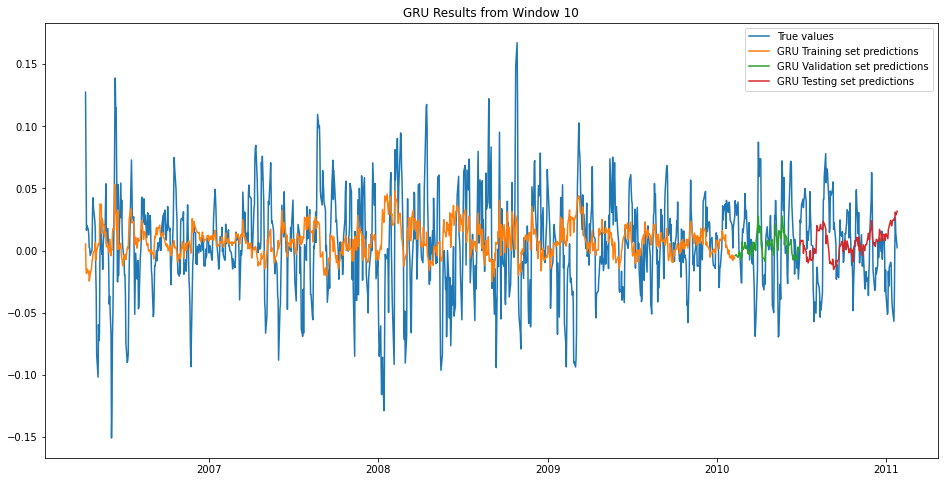

Window 11: 
Training datapoints: 1500 - 2499
Validation datapoints: 2500 - 2599
Testing datapoints: 2600 - 2749

Results on Training set: 
MSE = 0.0013522516808381689
RMSE = 0.03677297487065969
MAE = 0.027772538338969654
R-Squared = 0.04441421289295622

Results on Validation set: 
MSE = 0.0006500127390986188
RMSE = 0.025495347401018463
MAE = 0.020703031990918302
R-Squared = -0.03254119731900529

Results on Testing set: 
MSE = 0.0007587831170644221
RMSE = 0.027546018170770566
MAE = 0.02131799577271285
R-Squared = -0.007285018449023628



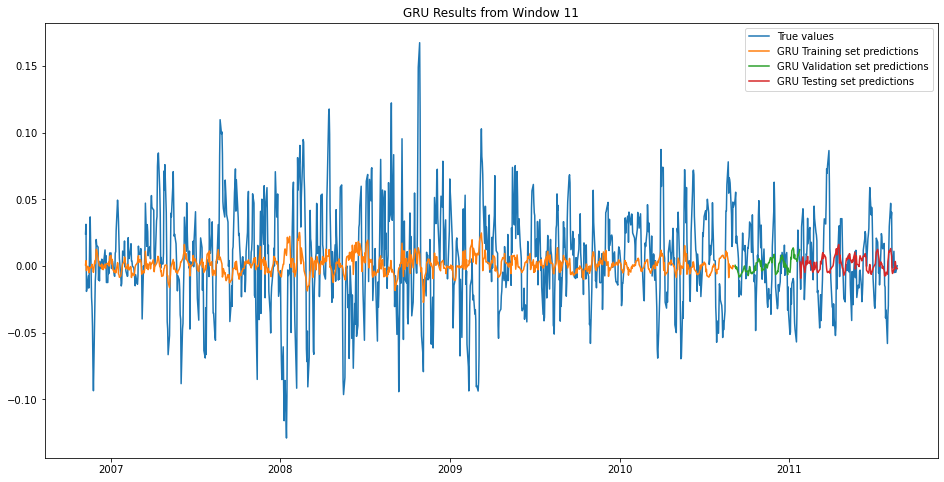

Window 12: 
Training datapoints: 1650 - 2649
Validation datapoints: 2650 - 2749
Testing datapoints: 2750 - 2899

Results on Training set: 
MSE = 0.001383614655407473
RMSE = 0.03719697105151806
MAE = 0.028919150372818486
R-Squared = 0.014643777865531282

Results on Validation set: 
MSE = 0.000556673337579896
RMSE = 0.023593925861964897
MAE = 0.018766977660236817
R-Squared = 0.05441348781496702

Results on Testing set: 
MSE = 0.0011070121748949387
RMSE = 0.03327179248094305
MAE = 0.025112272521902835
R-Squared = -0.13535088039925958



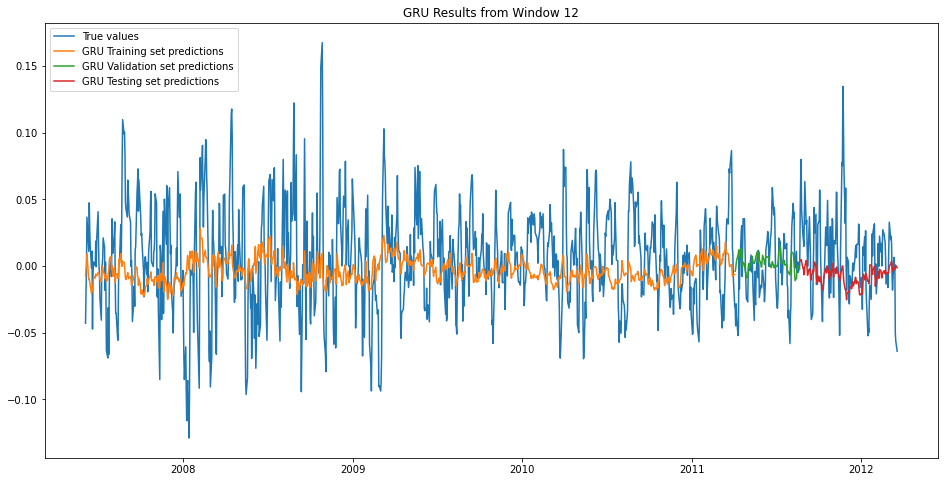

Window 13: 
Training datapoints: 1800 - 2799
Validation datapoints: 2800 - 2899
Testing datapoints: 2900 - 3049

Results on Training set: 
MSE = 0.0012396356310432368
RMSE = 0.035208459651669466
MAE = 0.02692386391991972
R-Squared = 0.06406602384316284

Results on Validation set: 
MSE = 0.0010076087307776015
RMSE = 0.031742853223640774
MAE = 0.02169929576078538
R-Squared = 0.01912874587426061

Results on Testing set: 
MSE = 0.0010488765207588616
RMSE = 0.03238636319130108
MAE = 0.02671797865090491
R-Squared = 0.021934786492490255



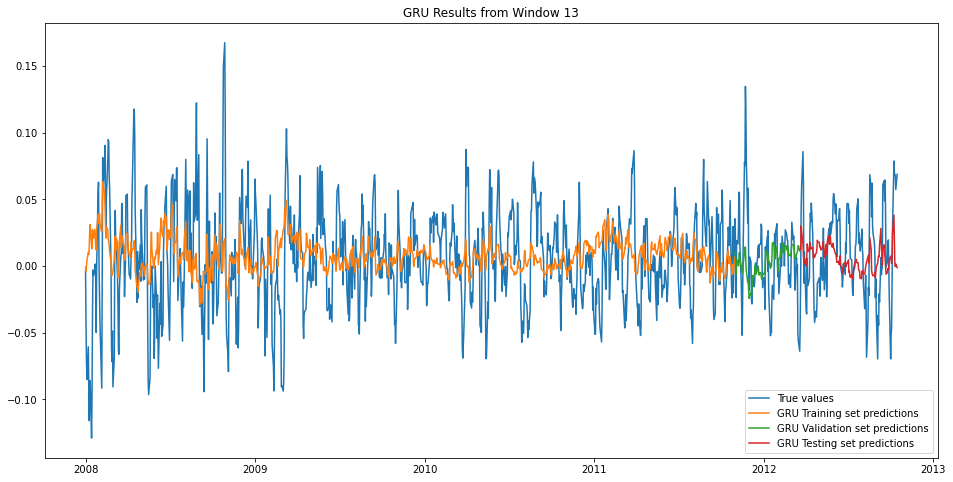

Window 14: 
Training datapoints: 1950 - 2949
Validation datapoints: 2950 - 3049
Testing datapoints: 3050 - 3199

Results on Training set: 
MSE = 0.0008395297036367722
RMSE = 0.028974638973363796
MAE = 0.022588583763914094
R-Squared = 0.22434654217469174

Results on Validation set: 
MSE = 0.0008008656502464087
RMSE = 0.028299569789069386
MAE = 0.023976350718743968
R-Squared = 0.3085224780896716

Results on Testing set: 
MSE = 0.002529423666968022
RMSE = 0.05029337597505284
MAE = 0.038249122905618695
R-Squared = -1.4951116976344339



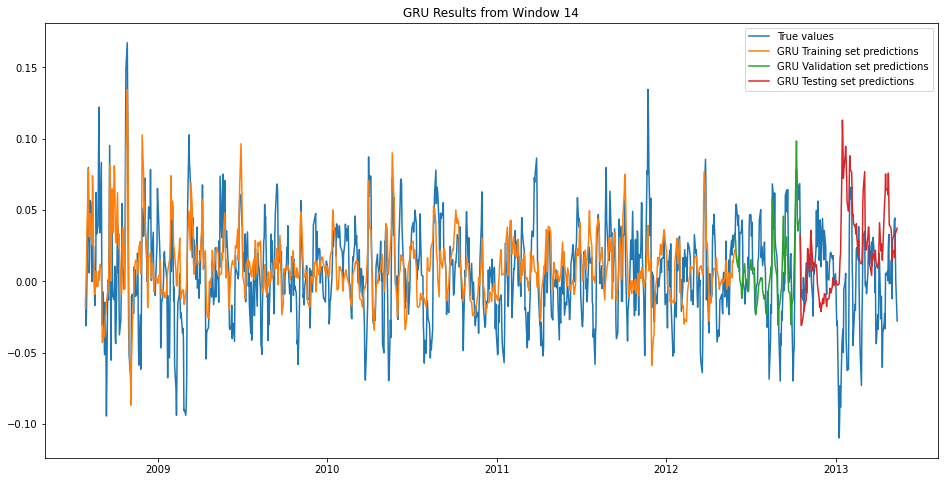

Window 15: 
Training datapoints: 2100 - 3099
Validation datapoints: 3100 - 3199
Testing datapoints: 3200 - 3349

Results on Training set: 
MSE = 0.0009511077976613153
RMSE = 0.030840035630026682
MAE = 0.024056894568201686
R-Squared = -0.01499626338512261

Results on Validation set: 
MSE = 0.0012670034247470895
RMSE = 0.03559499156829637
MAE = 0.026939853435006617
R-Squared = -0.043311855420777645

Results on Testing set: 
MSE = 0.001418254786364291
RMSE = 0.03765972366287744
MAE = 0.028439291630009862
R-Squared = -0.03824809529927298



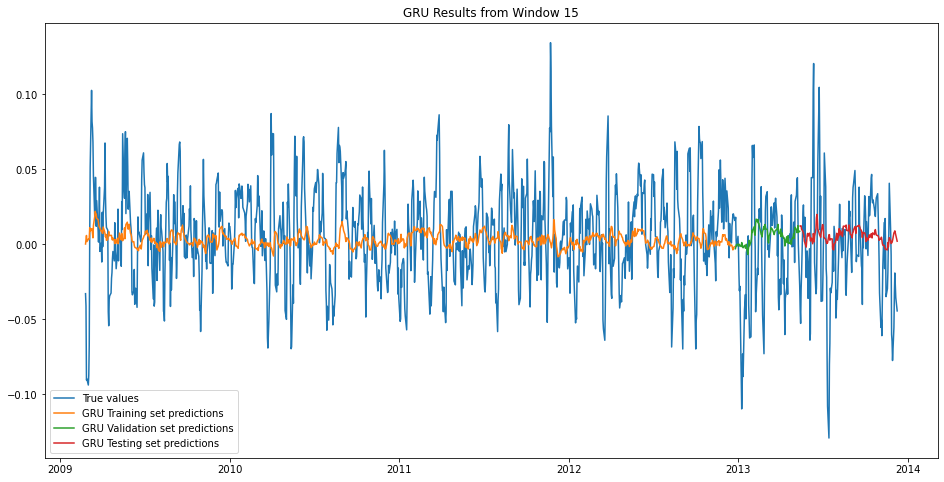

Window 16: 
Training datapoints: 2250 - 3249
Validation datapoints: 3250 - 3349
Testing datapoints: 3350 - 3499

Results on Training set: 
MSE = 0.0010214715635166475
RMSE = 0.03196046876246729
MAE = 0.02467035057777889
R-Squared = -0.008531093327577066

Results on Validation set: 
MSE = 0.0007936284598033343
RMSE = 0.02817141210169157
MAE = 0.021961893181605033
R-Squared = 0.01220595524021384

Results on Testing set: 
MSE = 0.0008088433885067827
RMSE = 0.028440172089964272
MAE = 0.02230365838662612
R-Squared = -0.01047287451981882



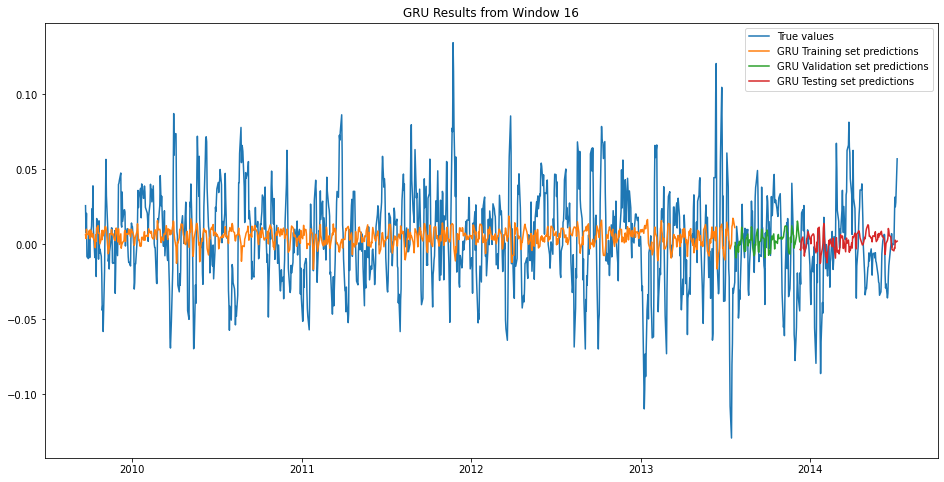

Window 17: 
Training datapoints: 2400 - 3399
Validation datapoints: 3400 - 3499
Testing datapoints: 3500 - 3649

Results on Training set: 
MSE = 0.0009918629108309235
RMSE = 0.03149385512811862
MAE = 0.02403491121730466
R-Squared = 0.04499849996598415

Results on Validation set: 
MSE = 0.0006024848648272371
RMSE = 0.024545567111542505
MAE = 0.01910800972950778
R-Squared = 0.18840201077883956

Results on Testing set: 
MSE = 0.0017952235964419309
RMSE = 0.04237007902331468
MAE = 0.03371223653729511
R-Squared = -0.10313864448569832



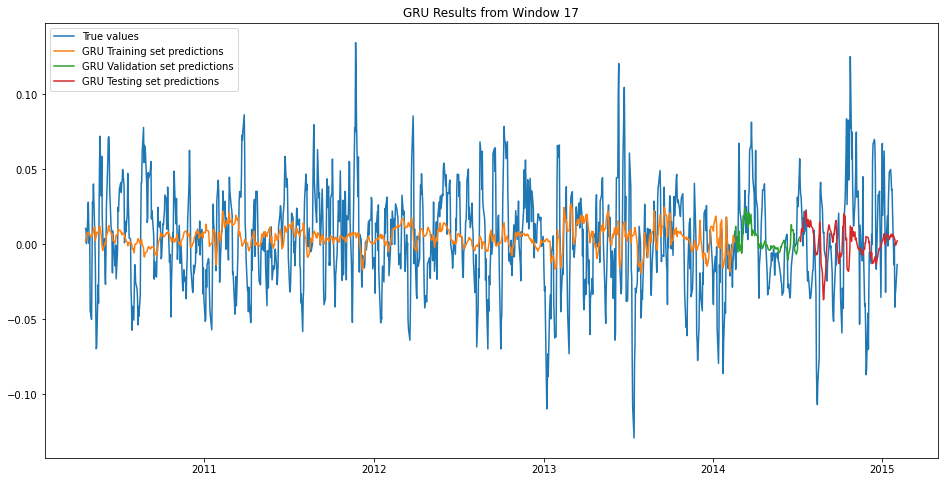

Window 18: 
Training datapoints: 2550 - 3549
Validation datapoints: 3550 - 3649
Testing datapoints: 3650 - 3799

Results on Training set: 
MSE = 0.0010349002525366145
RMSE = 0.03216986559711766
MAE = 0.024820007076582405
R-Squared = -0.011310026194925049

Results on Validation set: 
MSE = 0.0017438970847004397
RMSE = 0.04175999383022511
MAE = 0.033776996257190495
R-Squared = -0.01604788792787626

Results on Testing set: 
MSE = 0.0007169507931763397
RMSE = 0.026775936830974553
MAE = 0.02103243975132357
R-Squared = 0.1530242300679837



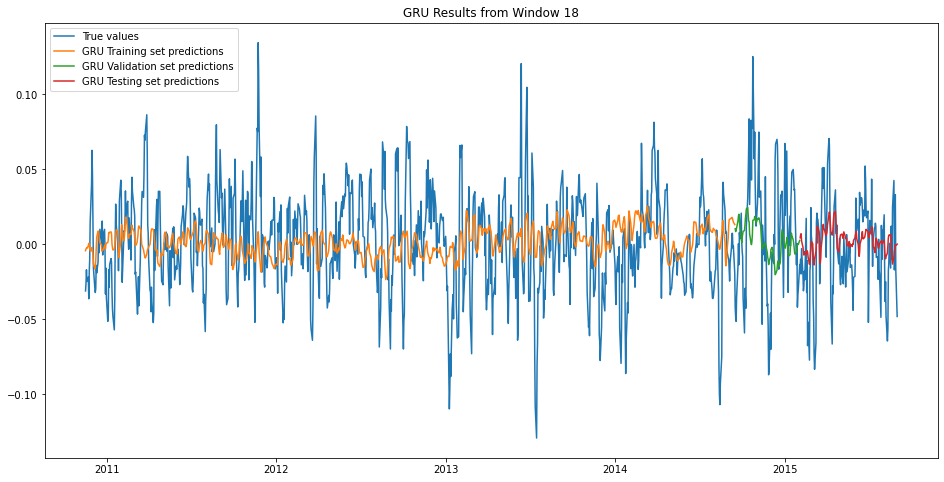

Window 19: 
Training datapoints: 2700 - 3699
Validation datapoints: 3700 - 3799
Testing datapoints: 3800 - 3949

Results on Training set: 
MSE = 0.0007524118356482017
RMSE = 0.027430126424211058
MAE = 0.020253049022116432
R-Squared = 0.3492112784752406

Results on Validation set: 
MSE = 0.0003834622141663205
RMSE = 0.019582191250376465
MAE = 0.014383451093516821
R-Squared = 0.3215851145022416

Results on Testing set: 
MSE = 0.0022281201342235456
RMSE = 0.0472029674302744
MAE = 0.03839556383202646
R-Squared = -0.33264967356373165



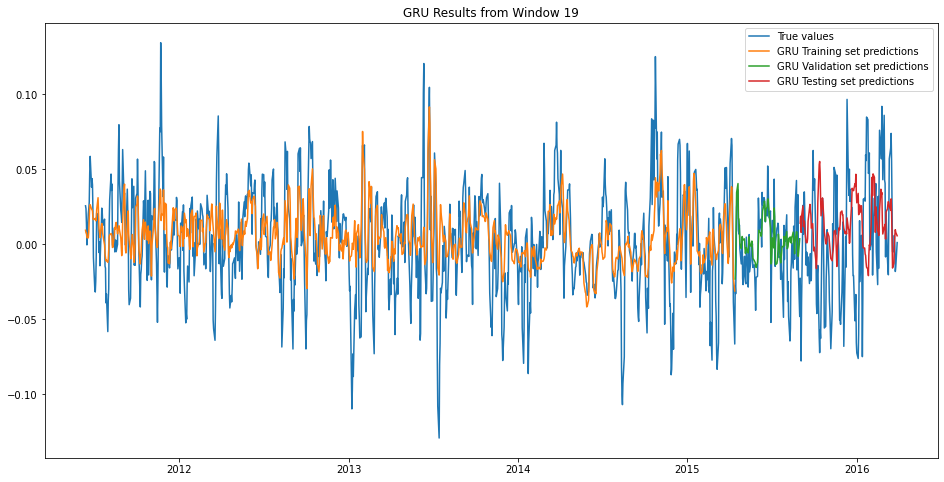

Window 20: 
Training datapoints: 2850 - 3849
Validation datapoints: 3850 - 3949
Testing datapoints: 3950 - 4099

Results on Training set: 
MSE = 0.0011444950924619955
RMSE = 0.033830387116644045
MAE = 0.025982066961593265
R-Squared = -0.012187978099136076

Results on Validation set: 
MSE = 0.0018598659405550553
RMSE = 0.043126163063215525
MAE = 0.035355675148990795
R-Squared = -0.11986340726189648

Results on Testing set: 
MSE = 0.0014995708548068342
RMSE = 0.03872429282513542
MAE = 0.028437625187497068
R-Squared = -0.004091781129038408



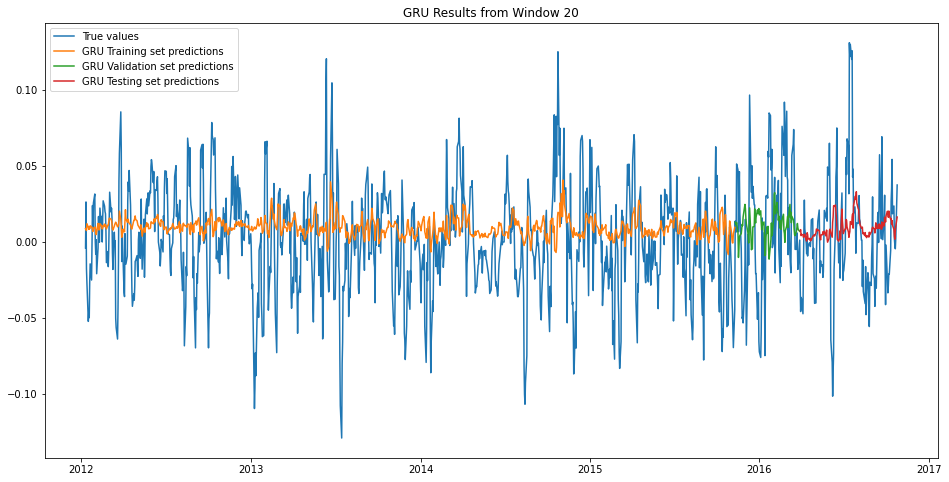

Window 21: 
Training datapoints: 3000 - 3999
Validation datapoints: 4000 - 4099
Testing datapoints: 4100 - 4249

Results on Training set: 
MSE = 0.001168950641539034
RMSE = 0.034189920174505145
MAE = 0.026360012076081723
R-Squared = 0.05452520159840313

Results on Validation set: 
MSE = 0.0017090550076778953
RMSE = 0.04134071851912948
MAE = 0.02950217253911964
R-Squared = 0.06403464761552269

Results on Testing set: 
MSE = 0.0015237598099146425
RMSE = 0.039035366142956086
MAE = 0.030516985479410983
R-Squared = -0.033545090024425406



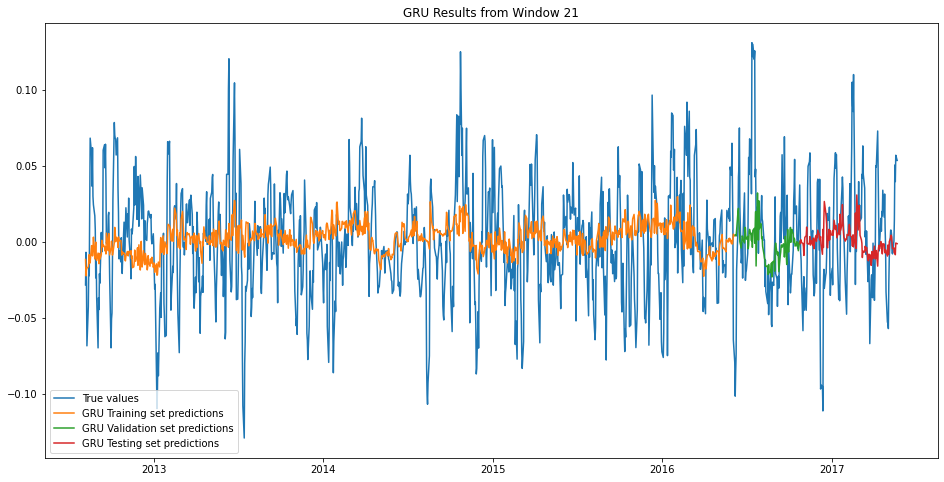

Window 22: 
Training datapoints: 3150 - 4149
Validation datapoints: 4150 - 4249
Testing datapoints: 4250 - 4399

Results on Training set: 
MSE = 0.0010610955275021587
RMSE = 0.03257446127723617
MAE = 0.02403289510546903
R-Squared = 0.17819140202295525

Results on Validation set: 
MSE = 0.0013120516519472506
RMSE = 0.03622225354595225
MAE = 0.026947325007698787
R-Squared = -0.012002370054593703

Results on Testing set: 
MSE = 0.0013566811754315389
RMSE = 0.03683315321054578
MAE = 0.02845599208866137
R-Squared = -0.05404247328943379



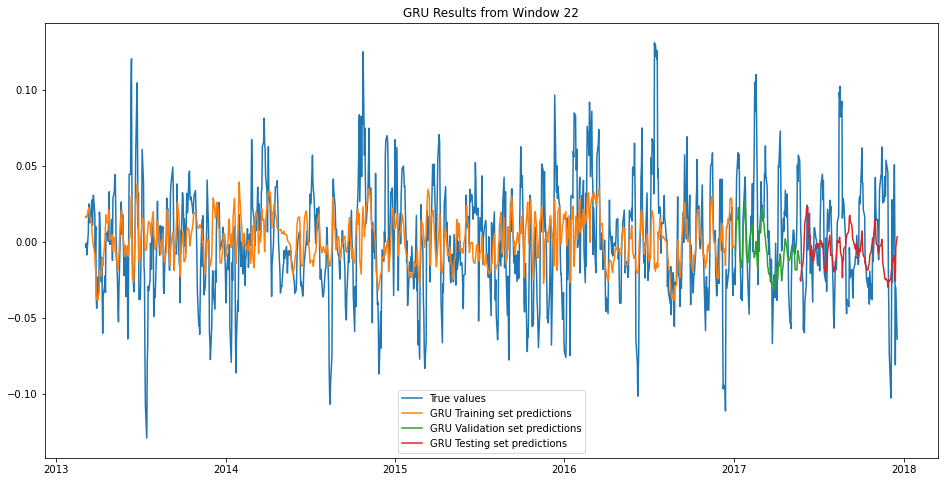

Window 23: 
Training datapoints: 3300 - 4299
Validation datapoints: 4300 - 4399
Testing datapoints: 4400 - 4549

Results on Training set: 
MSE = 0.001184046132490113
RMSE = 0.03440997141077152
MAE = 0.026203623055601626
R-Squared = 0.07413030400445186

Results on Validation set: 
MSE = 0.0016341180228134512
RMSE = 0.04042422569219417
MAE = 0.032051614104833946
R-Squared = -0.004241342759788047

Results on Testing set: 
MSE = 0.0015719389610606071
RMSE = 0.03964768544392733
MAE = 0.029832248368695396
R-Squared = -0.011453110751156848



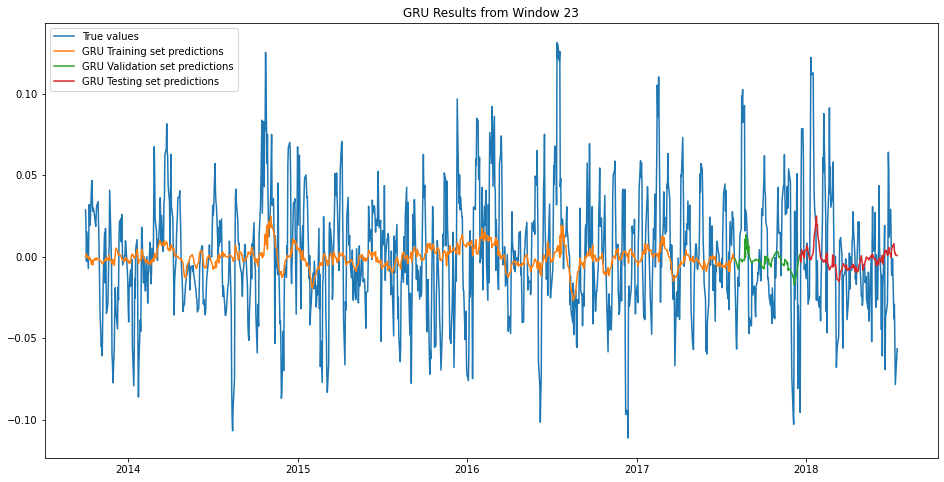

Window 24: 
Training datapoints: 3450 - 4449
Validation datapoints: 4450 - 4549
Testing datapoints: 4550 - 4699

Results on Training set: 
MSE = 0.0013643358412836093
RMSE = 0.03693691705169246
MAE = 0.027633703253572717
R-Squared = 0.043354871099943404

Results on Validation set: 
MSE = 0.0007441875615732112
RMSE = 0.02727980134775932
MAE = 0.02062347116158276
R-Squared = 0.06818161167379377

Results on Testing set: 
MSE = 0.0019541597101103776
RMSE = 0.04420587868270891
MAE = 0.03344493950964214
R-Squared = -0.06759663430761731



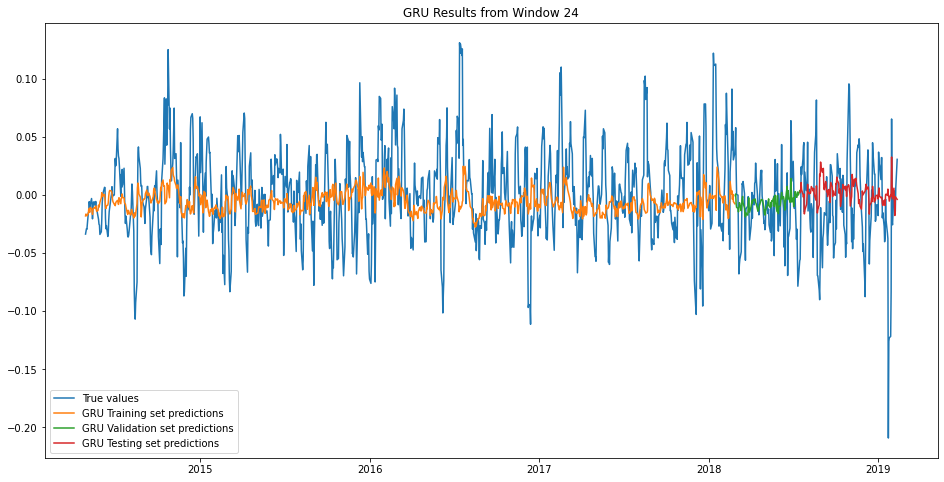

Window 25: 
Training datapoints: 3600 - 4599
Validation datapoints: 4600 - 4699
Testing datapoints: 4700 - 4925

Results on Training set: 
MSE = 0.0011610265731995745
RMSE = 0.034073840012531234
MAE = 0.025695675123921916
R-Squared = 0.17539961160412754

Results on Validation set: 
MSE = 0.0019558617463491857
RMSE = 0.0442251257358211
MAE = 0.03153046806851449
R-Squared = 0.05614578233534251

Results on Testing set: 
MSE = 0.0026904918249791143
RMSE = 0.051869951079397736
MAE = 0.039932538619866
R-Squared = -0.053359638425778844



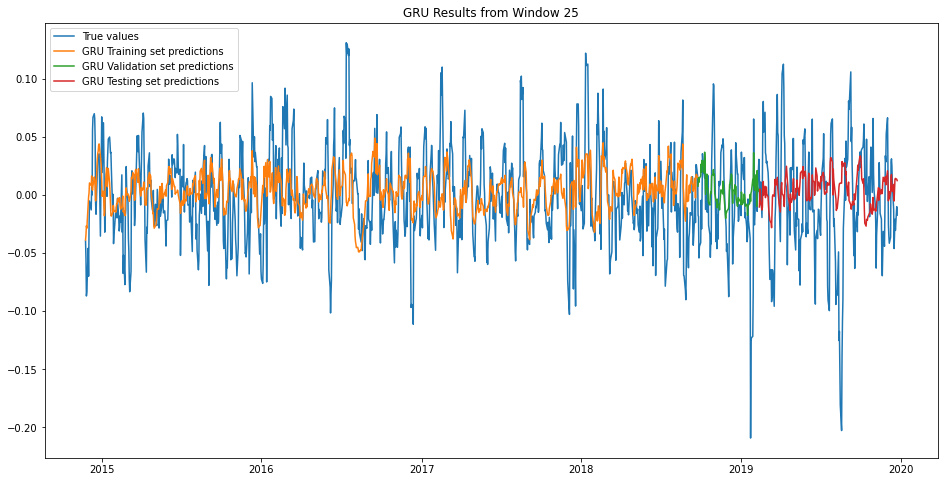

In [10]:
#Declaring model parameters
sequencelength = 193
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength
gru_predictions = np.zeros((numPredictions + extra,1)) 
gru_target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra

  #Print window information
  windowInfo(w, sequencelength, start, trainingSize, validationSize, end)
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #Create, train and test GRU 
  gru_model = create_gru()
  gru_history, gru_model = train_gru(gru_model, x_train, y_train, x_val, y_val)
  gru_predictions, gru_trainingPredictions, gru_valPredictions, gru_testingPredictions = makePredictions(gru_model, gru_predictions, x_train, x_val, x_test)
  evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, gru_trainingPredictions, gru_valPredictions, gru_testingPredictions)

  gru_target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Plot graph of forecasts
  trainGraph = pd.DataFrame(df[start : start + trainingSize])
  trainGraph['GRU Train Predictions'] = gru_trainingPredictions
  valGraph = pd.DataFrame(df[start + trainingSize : end - testingSize])
  valGraph['GRU Val Predictions'] = gru_valPredictions
  testGraph = pd.DataFrame(df[start + trainingSize + validationSize : end])
  testGraph['GRU Test Predictions'] = gru_testingPredictions
  
  #Plot GRU Results
  plt.figure(figsize=(16,8))
  plt.plot(df['Target'][start : end], label='True values')
  plt.plot(trainGraph['GRU Train Predictions'], label = 'GRU Training set predictions')
  plt.plot(valGraph['GRU Val Predictions'], label = 'GRU Validation set predictions')
  plt.plot(testGraph['GRU Test Predictions'], label = 'GRU Testing set predictions')
  plt.title("GRU Results from Window " + str(w + 1))
  plt.legend(loc = 'best')
  plt.show()

  #Update window parameters
  start += testingSize
  end += testingSize

**Naive and Drift Forecasting Implementation**

In [11]:
def naiveForecasts(dataset, begin, horizon, testingSize):
  '''
  Naive forecasting model
  @params:
    dataset - data to be used
    begin - Index of the test set
    testingSize - Size of the test set
  @returns:
    naive - forecasts for the window
  '''
  naive = dataset[begin-horizon:begin+testingSize-horizon,0].copy()
  return naive.reshape((naive.shape[0],1))

def driftForecasts(dataset, begin, horizon, testingSize):
  '''
  Drift forecasting model
  @params:
    dataset - data to be used
    begin - Index of the test set
    horizon - Size of the forecasting Horizon
    testingSize - Size of the test set
  @returns:
    drift - forecasts for the window
  '''
  drift = dataset[begin-horizon:begin+testingSize-horizon,0].copy()
  for i in range(2, drift.shape[0] + 1): 
    drift[i - 1] = drift[i - 1] + horizon * ((drift[i - 1] - drift[0]) / (i - 1))
  return drift.reshape((drift.shape[0],1))

#Declaring model parameters
sequencelength = 100
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength 
naive_predictions = np.zeros((numPredictions + extra,1)) 
drift_predictions = np.zeros((numPredictions + extra,1)) 
target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #naive and drift forecasts
  begin = start + trainingSize + validationSize
  naive_predictions[start - sequencelength: start - sequencelength + testingSize, :] = naiveForecasts(dataset, begin, forecastHorizon, testingSize)
  drift_predictions[start - sequencelength: start - sequencelength + testingSize, :] = driftForecasts(dataset, begin, forecastHorizon, testingSize)
  target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Update window parameters
  start += testingSize
  end += testingSize

print("Naive and Drift Forecasts completed")

Naive and Drift Forecasts completed


**Overall Results**

In [12]:
def overall(actual, predictions, model):
  '''
  Calculate the overall performance of the model
  @params:
    actual - True Values
    predictions - Predicted Values
    model - Name of the model used
  '''
  mse = mean_squared_error(actual, predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(actual, predictions)
  r2 = r2_score(actual, predictions)

  print(model + " results on the Testing set")
  print('MSE = ' + str(mse))
  print('RMSE = ' + str(rmse))
  print('MAE = ' + str(mae))
  print('R-Squared = ' + str(r2))
  print()

#Performance Metrics
overall(lstm_target, lstm_predictions, "LSTM model")
overall(gru_target, gru_predictions, "GRU model")
overall(target, naive_predictions, "Naive model")
overall(target, drift_predictions, "Drift model")

#For Plots
numpreds = 0
if lstm_predictions.shape[0] <= gru_predictions.shape[0]:
  numpreds = lstm_predictions.shape[0]
else:
  numpreds = gru_predictions.shape[0]

testGraph = pd.DataFrame(df[-numpreds:]['Target'])
testGraph['LSTM'] = lstm_predictions[-numpreds:]
testGraph['GRU'] = gru_predictions[-numpreds:]
testGraph['Naive'] = naive_predictions[-numpreds:]
testGraph['Drift'] = drift_predictions[-numpreds:]

LSTM model results on the Testing set
MSE = 0.0015632453906036712
RMSE = 0.03953789815611942
MAE = 0.030528806120297576
R-Squared = -0.12934374934010462

GRU model results on the Testing set
MSE = 0.0014963633631175687
RMSE = 0.038682856191309976
MAE = 0.02934256077457489
R-Squared = -0.0744646794838435

Naive model results on the Testing set
MSE = 0.002899788653454345
RMSE = 0.05384968573217809
MAE = 0.04153801791138342
R-Squared = -1.10397720696352

Drift model results on the Testing set
MSE = 0.0035812243398106406
RMSE = 0.05984333162358727
MAE = 0.045524181113393354
R-Squared = -1.59840122314045



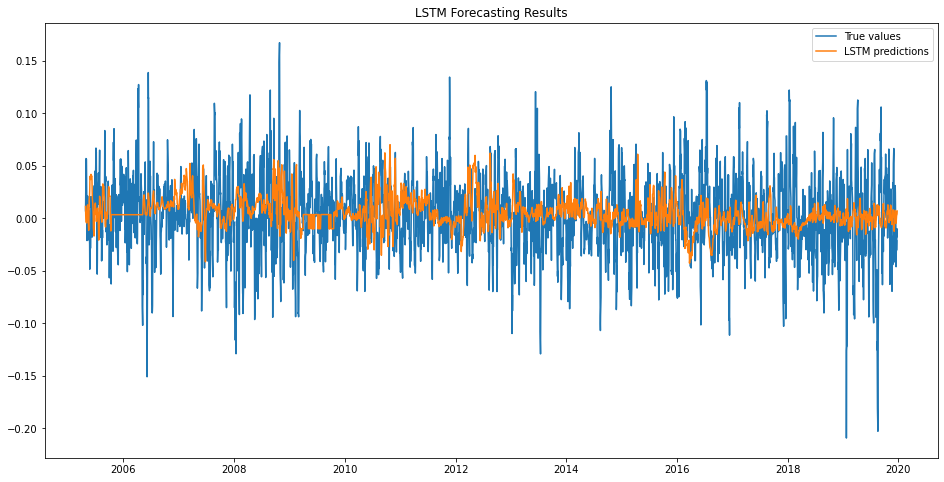

In [13]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['LSTM'], label = 'LSTM predictions')
plt.title("LSTM Forecasting Results")
plt.legend()
plt.show()

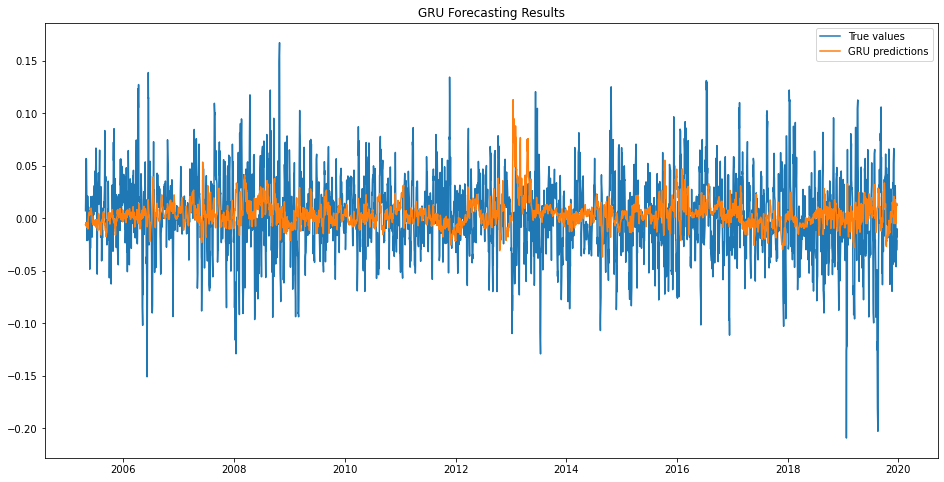

In [14]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['GRU'], label = 'GRU predictions')
plt.title("GRU Forecasting Results")
plt.legend()
plt.show()

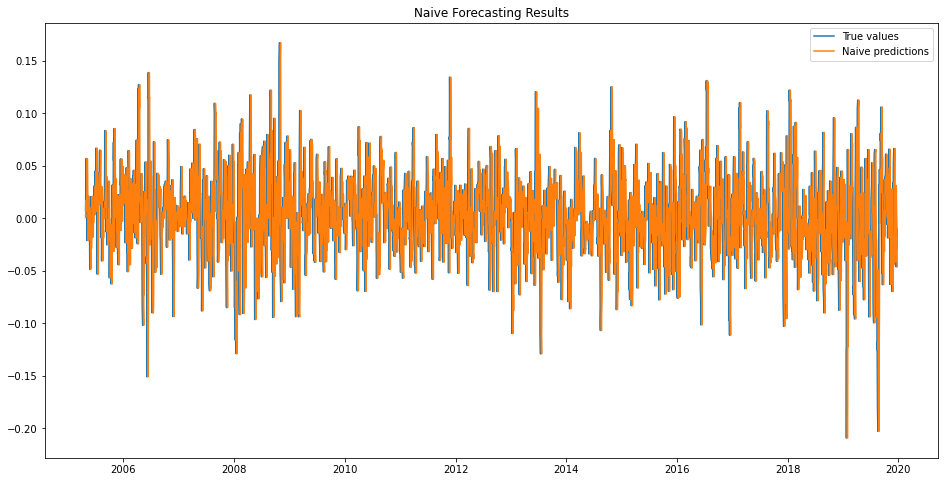

In [15]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['Naive'], label = 'Naive predictions')
plt.title("Naive Forecasting Results")
plt.legend()
plt.show()

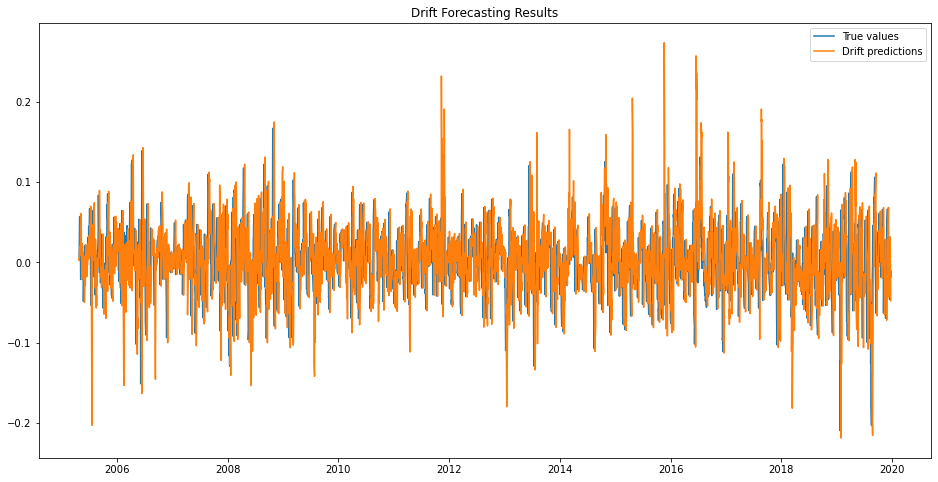

In [16]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['Drift'], label = 'Drift predictions')
plt.title("Drift Forecasting Results")
plt.legend()
plt.show()

**Save the predictions to a csv file**

In [17]:
savePredictions = pd.DataFrame(df[-numpreds:]['Target'])

savePredictions['SHP LSTM'] = lstm_predictions[-numpreds:]
savePredictions['SHP GRU'] = gru_predictions[-numpreds:]
savePredictions['SHP Naive'] = naive_predictions[-numpreds:]
savePredictions['SHP Drift'] = drift_predictions[-numpreds:]
savePredictions.drop(['Target'], axis=1, inplace=True)

savePredictions.to_csv(r'./SHP_Predictions.csv', index=True, header=True)

In [18]:
savePredictions.head()

SHP LSTM   SHP GRU  SHP Naive  SHP Drift
Date                                                
2005-04-26  0.011311 -0.006095   0.003630   0.005110
2005-04-27  0.003312 -0.006483   0.000725   0.002035
2005-04-28 -0.000674 -0.003980   0.007273   0.008914
2005-04-29 -0.002966 -0.005528   0.017304   0.019450
2005-05-02 -0.004167 -0.006545   0.017304   0.019428